In [125]:
import sys
import os

# Add the project root directory to the Python path
project_root = os.path.abspath("..")  # Adjust based on your folder structure
sys.path.append(project_root)

In [126]:
import torch
import torch.nn as nn
import torch.optim as optim
import importlib
from collections import deque
import random
import numpy as np
from tactix.utils import *
from no_use.tactixEnvironment_with_opp_random import TactixEnvironment
from tactix.tactixGame import TactixGame
import matplotlib.pyplot as plt

importlib.reload(sys.modules['tactix.tactixGame'])
importlib.reload(sys.modules['tactix.tactixEnvironment'])
importlib.reload(sys.modules['tactix.utils'])


<module 'tactix.utils' from '/Users/alibal/Desktop/tactix-game/tactix/utils.py'>

In [127]:
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(state_size, 50)
        self.layer2 = nn.Linear(50, 125)
        self.output = nn.Linear(125, action_size)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        return self.output(x)  # Outputs Q-values for each action

In [128]:
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, transition):
        """Store a transition (s, a, r, s')"""
        self.memory.append(transition)

    def sample(self, batch_size):
        """Sample a batch of transitions"""
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [149]:
class DQNAgent:
    def __init__(self, state_size, action_size, lr=1e-3, gamma=0.9, epsilon_start=1.0, epsilon_end=0.1, epsilon_decay=0.995):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_end
        self.epsilon_decay = epsilon_decay

        # Q-Networks
        self.q_network = DQN(state_size, action_size)
        self.target_network = DQN(state_size, action_size)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        # Optimizer
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)

        # Replay Memory
        self.memory = ReplayMemory(capacity=10000)

    def select_action(self, state, valid_moves_mask):
        """
        Epsilon-greedy action selection with invalid move masking.
        """
        if random.random() < self.epsilon:
            # Randomly select from the entire action space (125 actions), but only valid ones
            valid_indices = torch.where(valid_moves_mask[0] == 1)[0]
            action = random.choice(valid_indices.tolist())
            return action
        else:
            with torch.no_grad():
                q_values = self.q_network(state)
                # Mask invalid actions by setting them to -inf
                q_values[valid_moves_mask == 0] = -float('inf')
                return q_values.argmax().item()

    def update_target_network(self):
        """Update the target network to match the Q-network"""
        self.target_network.load_state_dict(self.q_network.state_dict())

    def train(self, batch_size):
        """Train the Q-network using experience replay"""
        if len(self.memory) < batch_size:
            
            return  # Not enough samples to train

        # Sample a batch of transitions
        transitions = self.memory.sample(batch_size)
        batch = list(zip(*transitions))

        states = torch.stack(batch[0])
        actions = torch.stack(batch[1])
        rewards = torch.tensor(batch[2])
        next_states = torch.stack(batch[3])
        dones = torch.tensor(batch[4], dtype=torch.bool)

        states = states.view(states.size(0), -1)  # Flatten to (batch_size, state_size)
        next_states = next_states.view(next_states.size(0), -1)  # Flatten to (batch_size, state_size)
        
        

        # Compute Q-values
        q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze()

        # States shape: torch.Size([64, 25])
        # Actions shape: torch.Size([64])
        # Q-values shape: torch.Size([64])

        # Compute target Q-values
        with torch.no_grad():
            max_next_q_values = self.target_network(next_states).max(1)[0]
            target_q_values = rewards + (1 - dones.float()) * self.gamma * max_next_q_values

        # Loss and optimization
        loss = nn.SmoothL1Loss()(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Decay epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

Episode 0/10000, Avg Reward: 1.00, Win Rate: 100.00%, Epsilon: 1.00
Episode 100/10000, Avg Reward: -0.04, Win Rate: 48.00%, Epsilon: 0.10
Episode 200/10000, Avg Reward: -0.18, Win Rate: 41.00%, Epsilon: 0.10
Episode 300/10000, Avg Reward: -0.04, Win Rate: 48.00%, Epsilon: 0.10
Episode 400/10000, Avg Reward: -0.08, Win Rate: 46.00%, Epsilon: 0.10
Episode 500/10000, Avg Reward: 0.12, Win Rate: 56.00%, Epsilon: 0.10
Episode 600/10000, Avg Reward: 0.18, Win Rate: 59.00%, Epsilon: 0.10
Episode 700/10000, Avg Reward: -0.04, Win Rate: 48.00%, Epsilon: 0.10
Episode 800/10000, Avg Reward: -0.20, Win Rate: 40.00%, Epsilon: 0.10
Episode 900/10000, Avg Reward: -0.04, Win Rate: 48.00%, Epsilon: 0.10
Episode 1000/10000, Avg Reward: 0.16, Win Rate: 58.00%, Epsilon: 0.10
Episode 1100/10000, Avg Reward: -0.08, Win Rate: 46.00%, Epsilon: 0.10
Episode 1200/10000, Avg Reward: 0.00, Win Rate: 50.00%, Epsilon: 0.10
Episode 1300/10000, Avg Reward: 0.06, Win Rate: 53.00%, Epsilon: 0.10
Episode 1400/10000, Avg

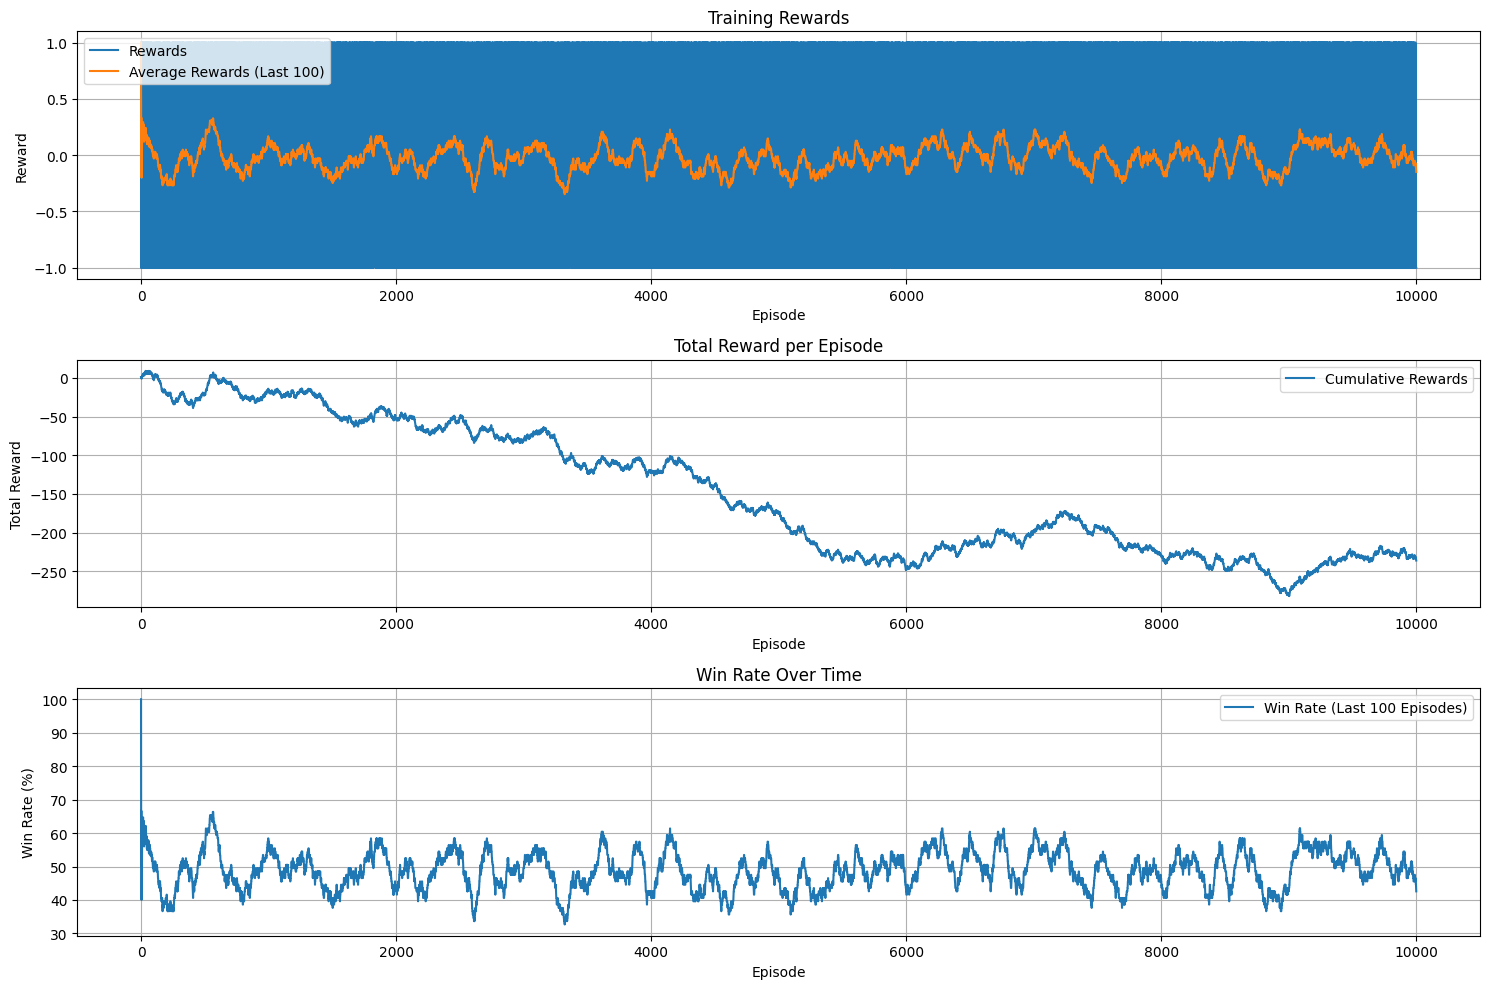

In [150]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Hyperparameters
NUM_EPISODES = 10000
BATCH_SIZE = 64
TARGET_UPDATE_FREQ = 10
MAX_STEPS = 100
LOG_INTERVAL = 100

# Initialize environment and agent
env = TactixEnvironment()
state_size = 25
action_size = 125
agent = DQNAgent(state_size, action_size)

# Logging
rewards_log = []
epsilon_log = []
win_log = []  # Tracks win/loss for calculating win rate

# Training loop
for episode in range(NUM_EPISODES):
    state, valid_moves_mask = env.reset()
    state = state.view(-1)  # Flatten the state to a 1D tensor
    state = state.unsqueeze(0)
    valid_moves_mask = valid_moves_mask.unsqueeze(0)  # Add batch dimension for masking

    episode_reward = 0
    won = False  # Tracks if the agent won this episode

    for step in range(MAX_STEPS):
        action = agent.select_action(state, valid_moves_mask)
        next_state, reward, done, valid_moves_mask = env.step(action)
        next_state = next_state.view(-1).unsqueeze(0)
        valid_moves_mask = valid_moves_mask.unsqueeze(0)

        # Store transition
        agent.memory.push((state, torch.tensor(action), reward, next_state, done))
        agent.train(BATCH_SIZE)

        state = next_state
        episode_reward += reward

        if done:
            won = reward > 0  # Agent wins if it receives a positive reward
            break

    rewards_log.append(episode_reward)
    epsilon_log.append(agent.epsilon)
    win_log.append(1 if won else 0)

    # Update target network
    if episode % TARGET_UPDATE_FREQ == 0:
        agent.update_target_network()

    # Log progress
    if episode % LOG_INTERVAL == 0:
        avg_reward = np.mean(rewards_log[-LOG_INTERVAL:]) if len(rewards_log) >= LOG_INTERVAL else np.mean(rewards_log)
        win_rate = np.mean(win_log[-LOG_INTERVAL:]) * 100 if len(win_log) >= LOG_INTERVAL else np.mean(win_log) * 100
        print(f"Episode {episode}/{NUM_EPISODES}, Avg Reward: {avg_reward:.2f}, Win Rate: {win_rate:.2f}%, Epsilon: {agent.epsilon:.2f}")

# Plot results after training
plt.figure(figsize=(15, 10))

# Rewards Plot
plt.subplot(3, 1, 1)
plt.plot(rewards_log, label="Rewards")
plt.plot(
    [np.mean(rewards_log[max(0, i - LOG_INTERVAL):i + 1]) for i in range(len(rewards_log))],
    label="Average Rewards (Last 100)",
)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Training Rewards")
plt.legend()
plt.grid()

# Total Reward per Episode
plt.subplot(3, 1, 2)
plt.plot(np.cumsum(rewards_log), label="Cumulative Rewards")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward per Episode")
plt.legend()
plt.grid()

# Win Rate Plot
plt.subplot(3, 1, 3)
plt.plot(
    [np.mean(win_log[max(0, i - LOG_INTERVAL):i + 1]) * 100 for i in range(len(win_log))],
    label="Win Rate (Last 100 Episodes)",
)
plt.xlabel("Episode")
plt.ylabel("Win Rate (%)")
plt.title("Win Rate Over Time")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Save model
torch.save(agent.q_network.state_dict(), "final_model.pth")

In [188]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque
import matplotlib.pyplot as plt


class FlexibleDQN(nn.Module):

    """
    A DQN that takes a list of hidden layer sizes as parameter.
    Example layer_sizes = [50, 125] -> 2 hidden layers of sizes 50 and 125.
    """
    def __init__(self, state_size, action_size, layer_sizes):
        super(FlexibleDQN, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        
        # Create a list of linear layers
        # E.g., if layer_sizes=[50,125], 
        # we want Linear(state_size, 50), then Linear(50,125), then Linear(125,action_size)
        
        # Build a sequence of Linear + ReLU (except for the output layer)
        layers = []
        input_dim = state_size
        
        for hidden_size in layer_sizes:
            layers.append(nn.Linear(input_dim, hidden_size))
            layers.append(nn.ReLU())
            input_dim = hidden_size
        
        # Final layer: from the last hidden to the action output
        layers.append(nn.Linear(input_dim, action_size))
        
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)  # Outputs Q-values for each action

In [193]:
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, transition):
        """Store a transition (s, a, r, s')"""
        self.memory.append(transition)

    def sample(self, batch_size):
        """Sample a batch of transitions"""
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


class FlexibleDQNAgent:
    def __init__(
        self, 
        state_size, 
        action_size, 
        layer_sizes,
        lr=1e-3, 
        gamma=0.9, 
        epsilon_start=1.0, 
        epsilon_end=0.01, 
        epsilon_decay=0.999876,
        memory_capacity=10000,
        device='cpu'
    ):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.device = device
        
        # Q-Networks (main + target)
        self.q_network = FlexibleDQN(state_size, action_size, layer_sizes).to(self.device)
        self.target_network = FlexibleDQN(state_size, action_size, layer_sizes).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        # Optimizer
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)

        # Replay Memory
        self.memory = ReplayMemory(capacity=memory_capacity)

    def select_action(self, state, valid_moves_mask):
        """
        Epsilon-greedy action selection with invalid move masking.
        state: shape (1, state_size)
        valid_moves_mask: shape (1, action_size) -> 1/0 for valid moves
        """
        if random.random() < self.epsilon:
            valid_indices = torch.where(valid_moves_mask[0] == 1)[0]
            action = random.choice(valid_indices.tolist())
            return action
        else:
            with torch.no_grad():
                q_values = self.q_network(state.to(self.device))  # (1, action_size)
                # Mask invalid actions by setting them to -inf
                q_values[valid_moves_mask == 0] = -float('inf')
                return q_values.argmax(dim=1).item()

    def update_target_network(self):
        """Update the target network to match the Q-network"""
        self.target_network.load_state_dict(self.q_network.state_dict())

    def train_step(self, batch_size):
        """Train the Q-network using one batch from experience replay."""
        if len(self.memory) < batch_size:
            return  # Not enough samples to train
        
        # Sample a batch of transitions
        transitions = self.memory.sample(batch_size)
        # transitions is a list of tuples: (state, action, reward, next_state, done)
        batch = list(zip(*transitions))

        states = torch.stack(batch[0]).to(self.device)          # shape: [batch_size, 1, state_size]
        actions = torch.stack(batch[1]).to(self.device)         # shape: [batch_size]
        rewards = torch.tensor(batch[2], dtype=torch.float32).to(self.device)  # [batch_size]
        next_states = torch.stack(batch[3]).to(self.device)     # shape: [batch_size, 1, state_size]
        dones = torch.tensor(batch[4], dtype=torch.bool).to(self.device)       # [batch_size]
        
        # Flatten states: we have [batch_size, 1, state_size] => [batch_size, state_size]
        states = states.view(states.size(0), -1)
        next_states = next_states.view(next_states.size(0), -1)

        # Current Q-values
        q_values = self.q_network(states)
        # Gather Q-values for the taken actions
        # q_values shape is [batch_size, action_size], actions is [batch_size]
        q_values = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)

        # Target Q-values
        with torch.no_grad():
            max_next_q_values = self.target_network(next_states).max(1)[0]
            target_q_values = rewards + (1 - dones.float()) * self.gamma * max_next_q_values
        
        # Loss and optimization
        loss = nn.SmoothL1Loss()(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Decay epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

In [194]:
def run_training_experiment(
    env, 
    layer_structure, 
    gamma,
    epsilon_decay=0.99995, 
    num_episodes=100000,
    batch_size=64,
    target_update_freq=100,
    lr=1e-4,              # Slower LR if you like
    memory_capacity=10000 # Increase if you want
):
    """
    Train a FlexibleDQNAgent on the given environment, using the specified layer structure and gamma.
    
    Returns:
        (rewards_log, cumulative_rewards_log, win_log, epsilon_log)
    """
    state_size = 25
    action_size = 125

    # Create agent
    agent = FlexibleDQNAgent(
        state_size=state_size,
        action_size=action_size,
        layer_sizes=layer_structure,
        lr=lr,
        gamma=gamma,
        epsilon_start=1.0,
        epsilon_end=0.05,
        epsilon_decay=epsilon_decay,
        memory_capacity=memory_capacity
    )
    
    # Logging
    rewards_log = []
    cumulative_rewards_log = []
    win_log = []
    epsilon_log = []
    total_reward = 0.0  # For cumulative tracking
    
    for episode in range(num_episodes):
        state, valid_moves_mask = env.reset()
        state = state.view(-1).unsqueeze(0)         # shape: [1, state_size]
        valid_moves_mask = valid_moves_mask.unsqueeze(0)  # shape: [1, action_size]

        episode_reward = 0
        done = False

        while not done:
            action = agent.select_action(state, valid_moves_mask)
            next_state, reward, done, valid_moves_mask = env.step(action)
            next_state = next_state.view(-1).unsqueeze(0)
            valid_moves_mask = valid_moves_mask.unsqueeze(0)

            # Push to replay
            agent.memory.push((state.cpu(), 
                               torch.tensor(action).cpu(), 
                               reward, 
                               next_state.cpu(), 
                               done))

            # Train
            agent.train_step(batch_size)

            state = next_state
            episode_reward += reward

        # Update target
        if episode % target_update_freq == 0:
            agent.update_target_network()

        # Logging
        total_reward += episode_reward
        rewards_log.append(episode_reward)
        cumulative_rewards_log.append(total_reward)
        win_log.append(1 if episode_reward > 0 else 0)
        epsilon_log.append(agent.epsilon)

        # Print progress occasionally
        if (episode+1) % (num_episodes//10) == 0:  # e.g., 10% intervals
            avg_reward = np.mean(rewards_log[-100:]) if len(rewards_log) > 100 else np.mean(rewards_log)
            win_rate = 100.0 * np.mean(win_log[-100:]) if len(win_log) > 100 else 100.0 * np.mean(win_log)
            print(f"[{episode+1}/{num_episodes}] Layers={layer_structure}, Gamma={gamma}, "
                  f"AvgReward(Last100)={avg_reward:.2f}, WinRate(Last100)={win_rate:.2f}%, Eps={agent.epsilon:.3f}")

    return rewards_log, cumulative_rewards_log, win_log, epsilon_log

In [195]:
def main_experiments(env):
    layer_structures = [
        [50, 125],
        [125, 250, 250, 125],
        [50, 100, 125],
        [125, 250],
        [25, 50, 100, 125]
    ]
    gammas = [0.95, 0.9, 0.85, 0.8, 0.75, 0.7]
    epsilon_decay = 0.99995
    
    # We’ll store the results in a dictionary for plotting later
    results = {}  # (layer_tuple, gamma) -> (rewards_log, cumulative_rewards_log, win_log, epsilon_log)
    
    for structure in layer_structures:
        for gamma in gammas:
            print(f"=== Training with LayerStructure={structure} and Gamma={gamma} ===")
            r_log, c_log, w_log, e_log = run_training_experiment(
                env=env,
                layer_structure=structure,
                gamma=gamma,
                epsilon_decay=epsilon_decay,
                num_episodes=100000,      # or fewer for quick testing
                batch_size=64,
                target_update_freq=1000,
                lr=1e-4,
                memory_capacity=50000
            )
            results[(tuple(structure), gamma)] = (r_log, c_log, w_log, e_log)
            
            # Plot results for this combination
            fig, axs = plt.subplots(3, 1, figsize=(12, 12))
            
            # 1) Rewards
            axs[0].plot(r_log, label="Rewards")
            # rolling average
            rolling_avg_r = [np.mean(r_log[max(0, i-100):i+1]) for i in range(len(r_log))]
            axs[0].plot(rolling_avg_r, label="Average Rewards (Last 100)")
            axs[0].set_xlabel("Episode")
            axs[0].set_ylabel("Reward")
            axs[0].set_title(f"Rewards - Layers={structure}, Gamma={gamma}")
            axs[0].legend()
            axs[0].grid()
            
            # 2) Cumulative Rewards
            axs[1].plot(c_log, label="Cumulative Rewards")
            axs[1].set_xlabel("Episode")
            axs[1].set_ylabel("Total Reward")
            axs[1].set_title(f"Cumulative Rewards - Layers={structure}, Gamma={gamma}")
            axs[1].legend()
            axs[1].grid()
            
            # 3) Win Rate
            # rolling avg of the last 100 episodes in w_log
            rolling_win = [100.0*np.mean(w_log[max(0, i-100):i+1]) for i in range(len(w_log))]
            axs[2].plot(rolling_win, label="Win Rate (Last 100 Episodes)")
            axs[2].set_xlabel("Episode")
            axs[2].set_ylabel("Win Rate (%)")
            axs[2].set_title(f"Win Rate - Layers={structure}, Gamma={gamma}")
            axs[2].legend()
            axs[2].grid()
            
            plt.tight_layout()
            plt.show()
            
    return results

=== Training with LayerStructure=[50, 125] and Gamma=0.95 ===
[10000/100000] Layers=[50, 125], Gamma=0.95, AvgReward(Last100)=-0.12, WinRate(Last100)=44.00%, Eps=0.050
[20000/100000] Layers=[50, 125], Gamma=0.95, AvgReward(Last100)=-0.26, WinRate(Last100)=37.00%, Eps=0.050
[30000/100000] Layers=[50, 125], Gamma=0.95, AvgReward(Last100)=0.20, WinRate(Last100)=60.00%, Eps=0.050
[40000/100000] Layers=[50, 125], Gamma=0.95, AvgReward(Last100)=0.36, WinRate(Last100)=68.00%, Eps=0.050
[50000/100000] Layers=[50, 125], Gamma=0.95, AvgReward(Last100)=0.52, WinRate(Last100)=76.00%, Eps=0.050
[60000/100000] Layers=[50, 125], Gamma=0.95, AvgReward(Last100)=0.54, WinRate(Last100)=77.00%, Eps=0.050
[70000/100000] Layers=[50, 125], Gamma=0.95, AvgReward(Last100)=-0.28, WinRate(Last100)=36.00%, Eps=0.050
[80000/100000] Layers=[50, 125], Gamma=0.95, AvgReward(Last100)=0.14, WinRate(Last100)=57.00%, Eps=0.050
[90000/100000] Layers=[50, 125], Gamma=0.95, AvgReward(Last100)=-0.06, WinRate(Last100)=47.00%,

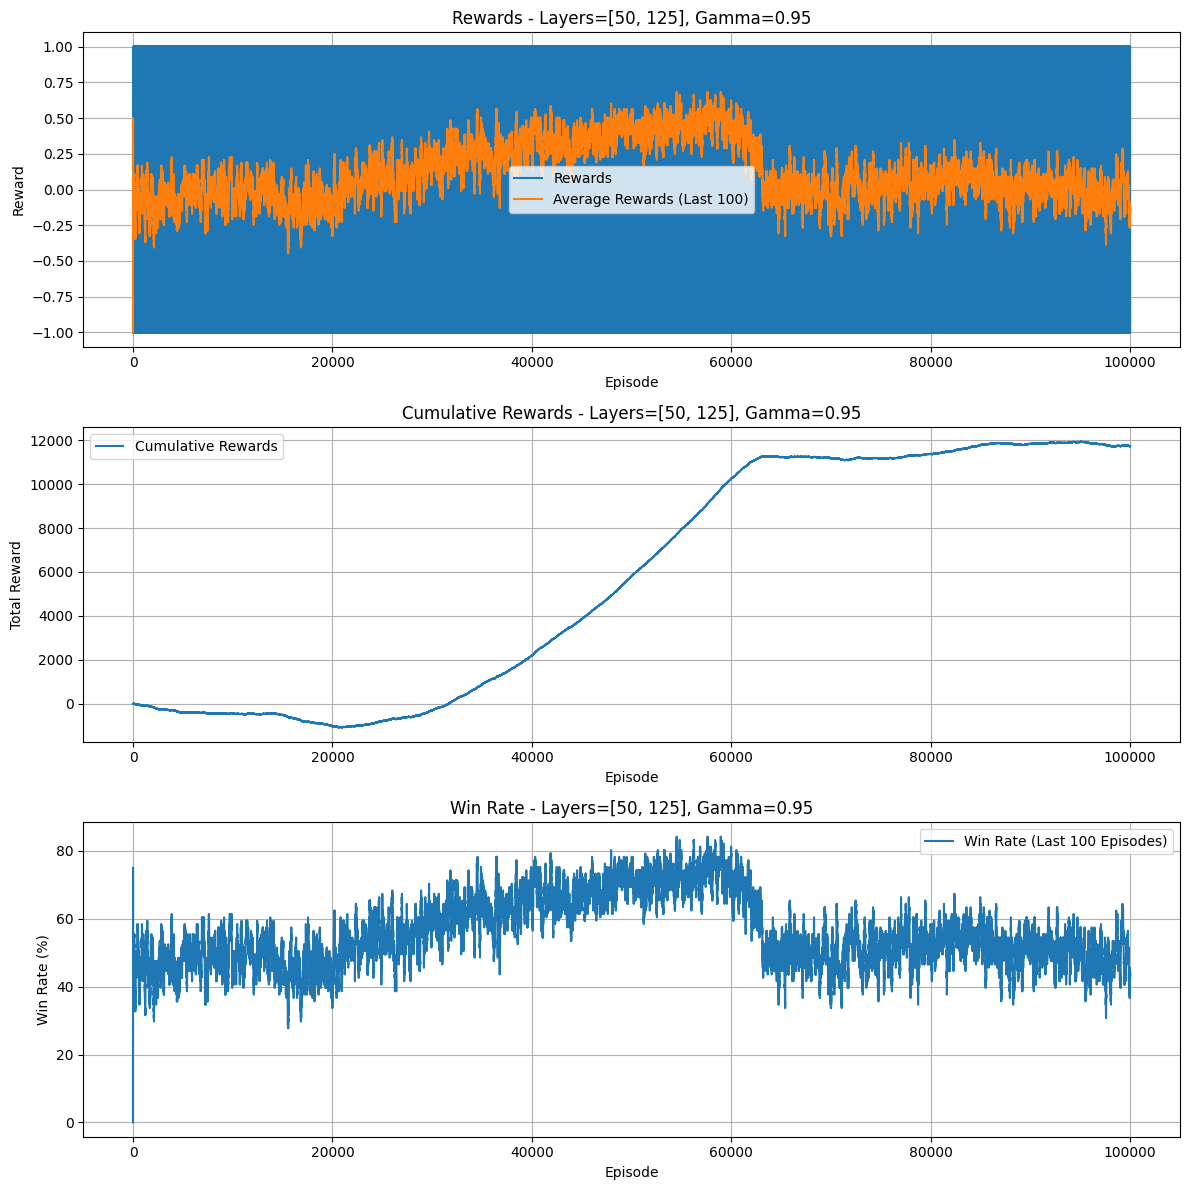

=== Training with LayerStructure=[50, 125] and Gamma=0.9 ===
[10000/100000] Layers=[50, 125], Gamma=0.9, AvgReward(Last100)=-0.30, WinRate(Last100)=35.00%, Eps=0.050
[20000/100000] Layers=[50, 125], Gamma=0.9, AvgReward(Last100)=-0.38, WinRate(Last100)=31.00%, Eps=0.050
[30000/100000] Layers=[50, 125], Gamma=0.9, AvgReward(Last100)=-0.22, WinRate(Last100)=39.00%, Eps=0.050
[40000/100000] Layers=[50, 125], Gamma=0.9, AvgReward(Last100)=-0.14, WinRate(Last100)=43.00%, Eps=0.050
[50000/100000] Layers=[50, 125], Gamma=0.9, AvgReward(Last100)=-0.02, WinRate(Last100)=49.00%, Eps=0.050
[60000/100000] Layers=[50, 125], Gamma=0.9, AvgReward(Last100)=-0.18, WinRate(Last100)=41.00%, Eps=0.050
[70000/100000] Layers=[50, 125], Gamma=0.9, AvgReward(Last100)=-0.32, WinRate(Last100)=34.00%, Eps=0.050
[80000/100000] Layers=[50, 125], Gamma=0.9, AvgReward(Last100)=-0.34, WinRate(Last100)=33.00%, Eps=0.050
[90000/100000] Layers=[50, 125], Gamma=0.9, AvgReward(Last100)=-0.28, WinRate(Last100)=36.00%, Eps=

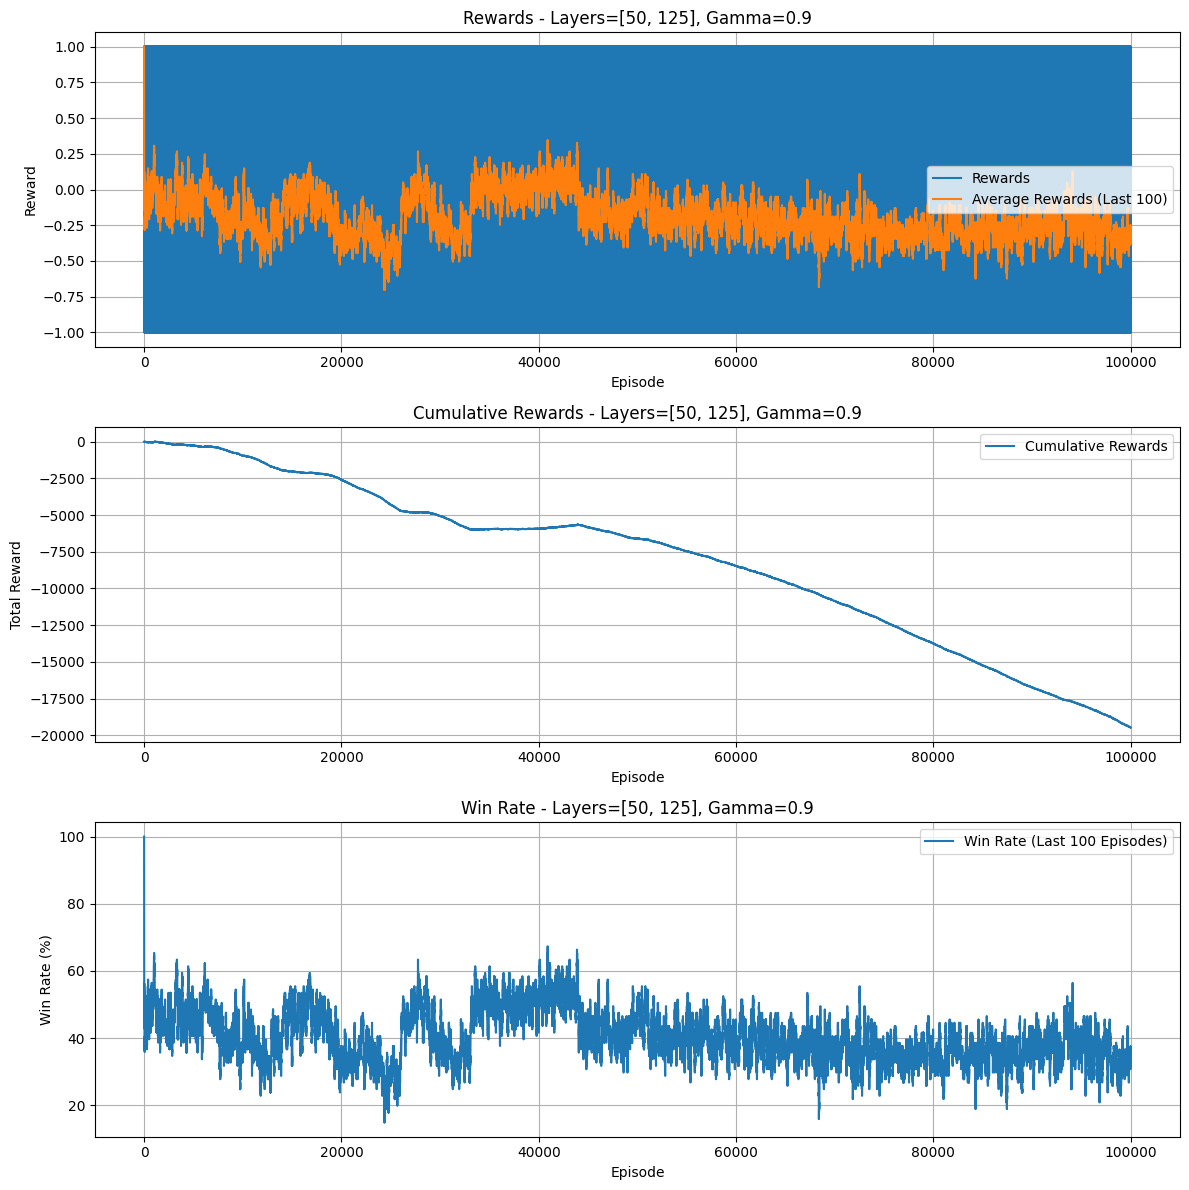

=== Training with LayerStructure=[50, 125] and Gamma=0.85 ===
[10000/100000] Layers=[50, 125], Gamma=0.85, AvgReward(Last100)=0.10, WinRate(Last100)=55.00%, Eps=0.050
[20000/100000] Layers=[50, 125], Gamma=0.85, AvgReward(Last100)=0.12, WinRate(Last100)=56.00%, Eps=0.050
[30000/100000] Layers=[50, 125], Gamma=0.85, AvgReward(Last100)=0.08, WinRate(Last100)=54.00%, Eps=0.050
[40000/100000] Layers=[50, 125], Gamma=0.85, AvgReward(Last100)=-0.04, WinRate(Last100)=48.00%, Eps=0.050
[50000/100000] Layers=[50, 125], Gamma=0.85, AvgReward(Last100)=-0.02, WinRate(Last100)=49.00%, Eps=0.050
[60000/100000] Layers=[50, 125], Gamma=0.85, AvgReward(Last100)=0.02, WinRate(Last100)=51.00%, Eps=0.050
[70000/100000] Layers=[50, 125], Gamma=0.85, AvgReward(Last100)=-0.02, WinRate(Last100)=49.00%, Eps=0.050
[80000/100000] Layers=[50, 125], Gamma=0.85, AvgReward(Last100)=-0.06, WinRate(Last100)=47.00%, Eps=0.050
[90000/100000] Layers=[50, 125], Gamma=0.85, AvgReward(Last100)=0.02, WinRate(Last100)=51.00%,

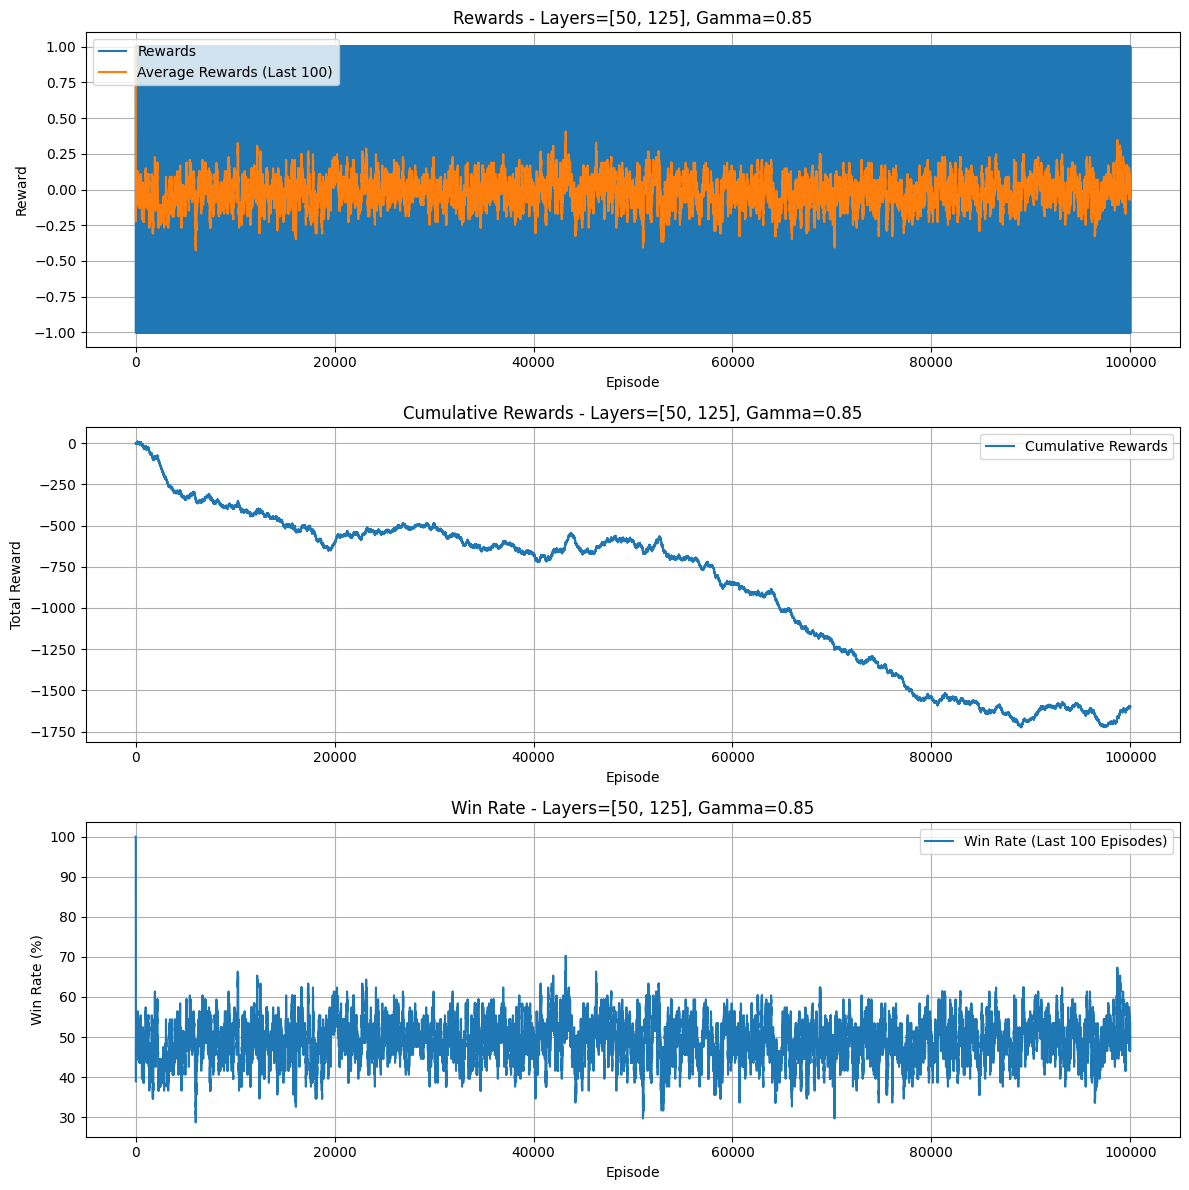

=== Training with LayerStructure=[50, 125] and Gamma=0.8 ===
[10000/100000] Layers=[50, 125], Gamma=0.8, AvgReward(Last100)=-0.10, WinRate(Last100)=45.00%, Eps=0.050
[20000/100000] Layers=[50, 125], Gamma=0.8, AvgReward(Last100)=-0.20, WinRate(Last100)=40.00%, Eps=0.050
[30000/100000] Layers=[50, 125], Gamma=0.8, AvgReward(Last100)=-0.06, WinRate(Last100)=47.00%, Eps=0.050
[40000/100000] Layers=[50, 125], Gamma=0.8, AvgReward(Last100)=-0.18, WinRate(Last100)=41.00%, Eps=0.050
[50000/100000] Layers=[50, 125], Gamma=0.8, AvgReward(Last100)=-0.28, WinRate(Last100)=36.00%, Eps=0.050
[60000/100000] Layers=[50, 125], Gamma=0.8, AvgReward(Last100)=-0.40, WinRate(Last100)=30.00%, Eps=0.050
[70000/100000] Layers=[50, 125], Gamma=0.8, AvgReward(Last100)=-0.34, WinRate(Last100)=33.00%, Eps=0.050
[80000/100000] Layers=[50, 125], Gamma=0.8, AvgReward(Last100)=-0.30, WinRate(Last100)=35.00%, Eps=0.050
[90000/100000] Layers=[50, 125], Gamma=0.8, AvgReward(Last100)=-0.34, WinRate(Last100)=33.00%, Eps=

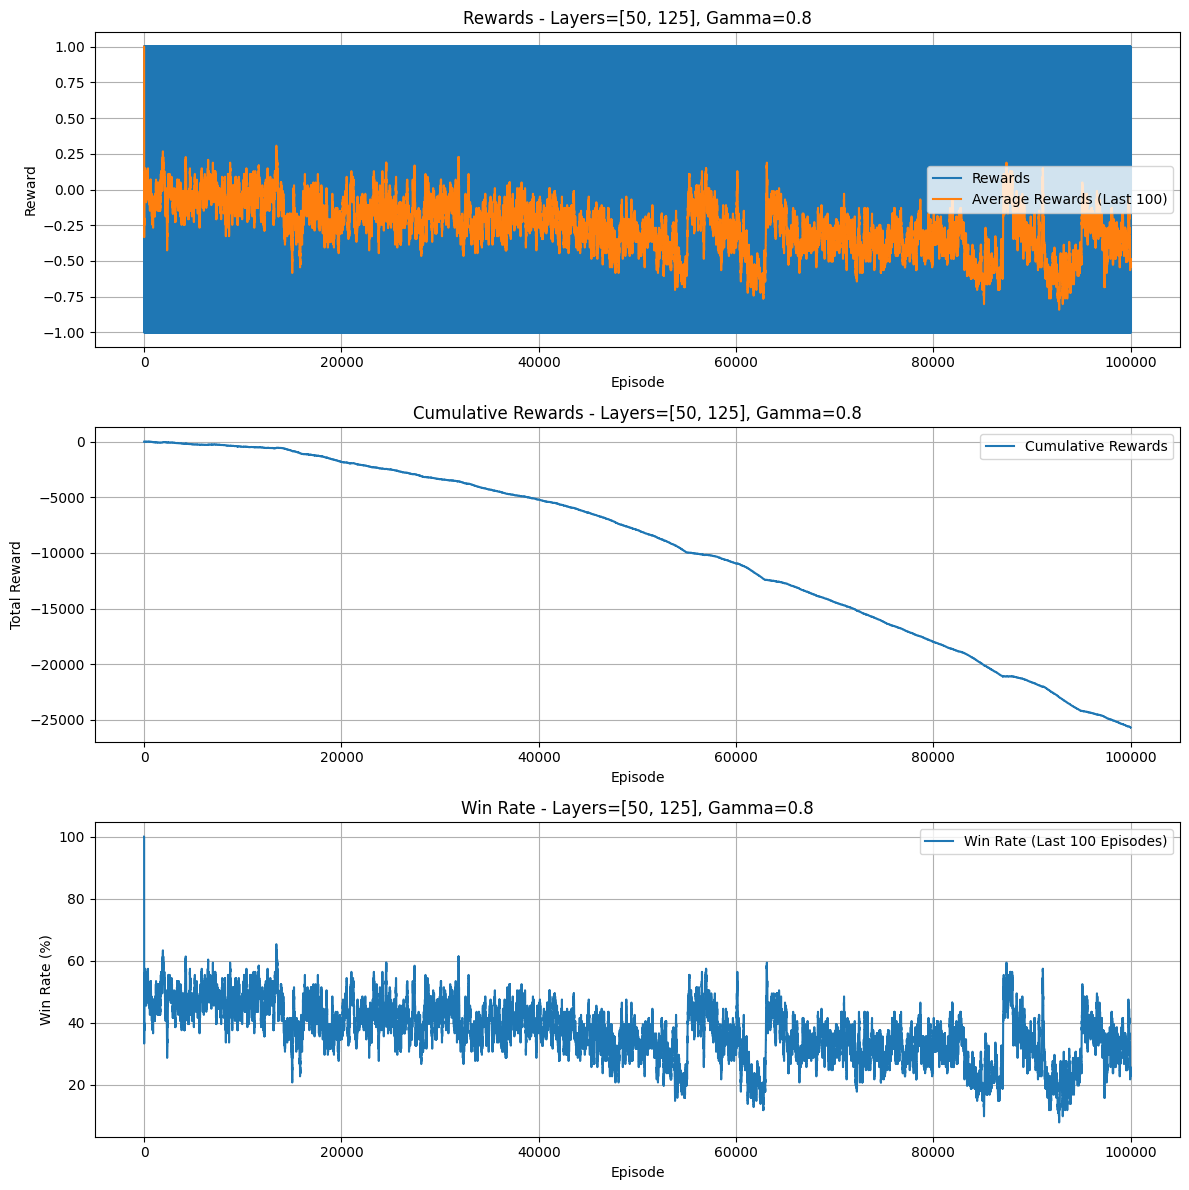

=== Training with LayerStructure=[50, 125] and Gamma=0.75 ===
[10000/100000] Layers=[50, 125], Gamma=0.75, AvgReward(Last100)=-0.14, WinRate(Last100)=43.00%, Eps=0.050
[20000/100000] Layers=[50, 125], Gamma=0.75, AvgReward(Last100)=-0.10, WinRate(Last100)=45.00%, Eps=0.050
[30000/100000] Layers=[50, 125], Gamma=0.75, AvgReward(Last100)=0.12, WinRate(Last100)=56.00%, Eps=0.050
[40000/100000] Layers=[50, 125], Gamma=0.75, AvgReward(Last100)=0.10, WinRate(Last100)=55.00%, Eps=0.050
[50000/100000] Layers=[50, 125], Gamma=0.75, AvgReward(Last100)=0.60, WinRate(Last100)=80.00%, Eps=0.050
[60000/100000] Layers=[50, 125], Gamma=0.75, AvgReward(Last100)=0.20, WinRate(Last100)=60.00%, Eps=0.050
[70000/100000] Layers=[50, 125], Gamma=0.75, AvgReward(Last100)=0.48, WinRate(Last100)=74.00%, Eps=0.050
[80000/100000] Layers=[50, 125], Gamma=0.75, AvgReward(Last100)=0.34, WinRate(Last100)=67.00%, Eps=0.050
[90000/100000] Layers=[50, 125], Gamma=0.75, AvgReward(Last100)=0.30, WinRate(Last100)=65.00%, E

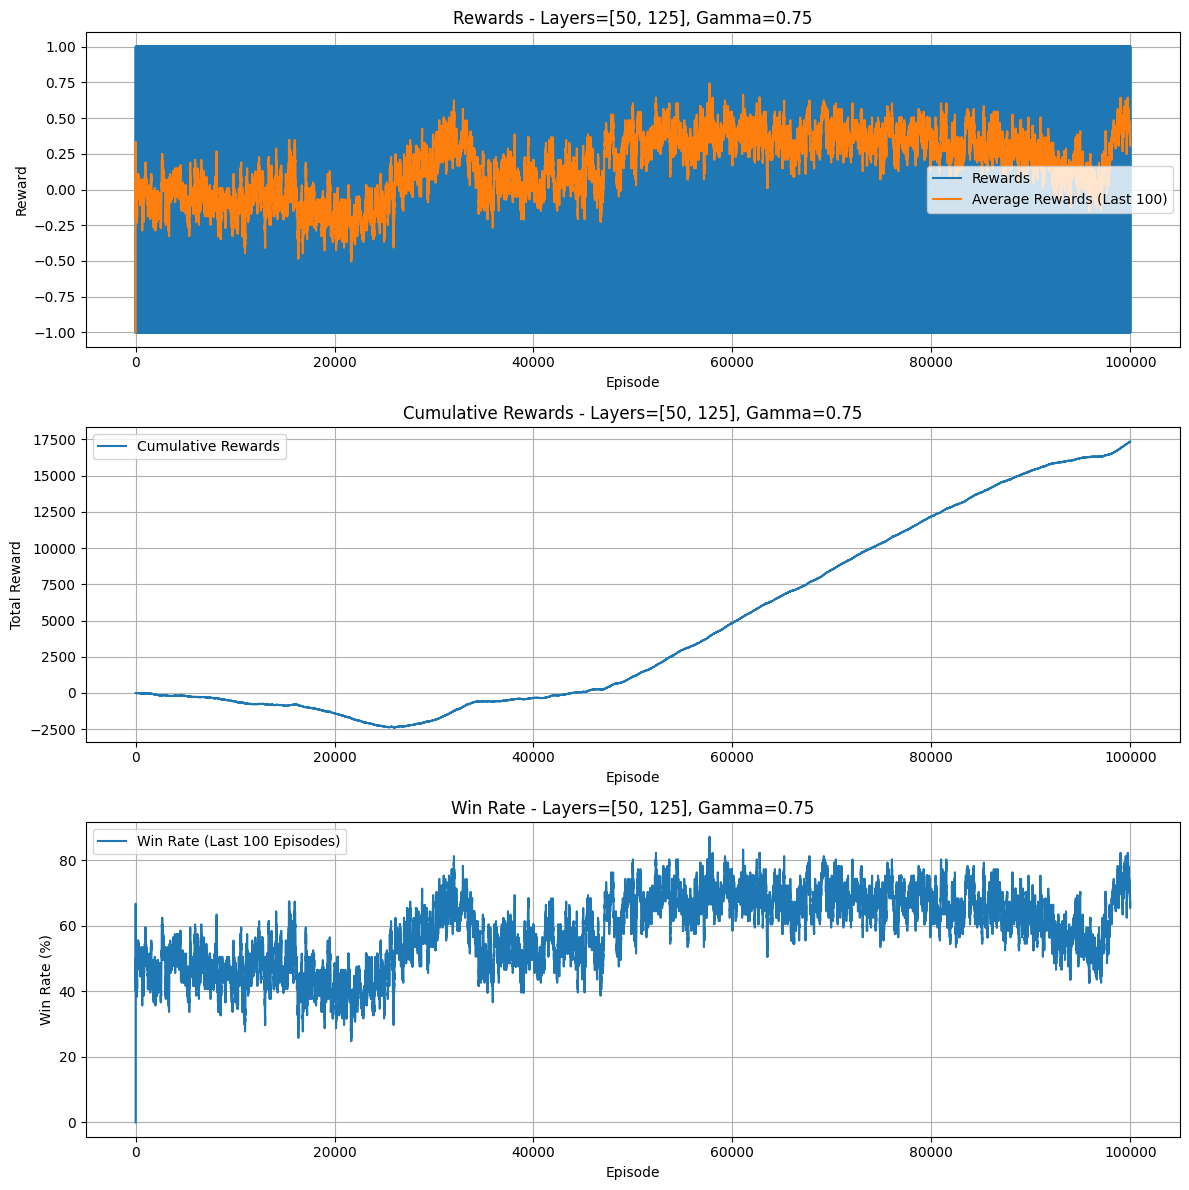

=== Training with LayerStructure=[50, 125] and Gamma=0.7 ===
[10000/100000] Layers=[50, 125], Gamma=0.7, AvgReward(Last100)=-0.04, WinRate(Last100)=48.00%, Eps=0.050
[20000/100000] Layers=[50, 125], Gamma=0.7, AvgReward(Last100)=0.00, WinRate(Last100)=50.00%, Eps=0.050
[30000/100000] Layers=[50, 125], Gamma=0.7, AvgReward(Last100)=-0.26, WinRate(Last100)=37.00%, Eps=0.050
[40000/100000] Layers=[50, 125], Gamma=0.7, AvgReward(Last100)=-0.10, WinRate(Last100)=45.00%, Eps=0.050
[50000/100000] Layers=[50, 125], Gamma=0.7, AvgReward(Last100)=-0.30, WinRate(Last100)=35.00%, Eps=0.050
[60000/100000] Layers=[50, 125], Gamma=0.7, AvgReward(Last100)=-0.50, WinRate(Last100)=25.00%, Eps=0.050
[70000/100000] Layers=[50, 125], Gamma=0.7, AvgReward(Last100)=-0.34, WinRate(Last100)=33.00%, Eps=0.050
[80000/100000] Layers=[50, 125], Gamma=0.7, AvgReward(Last100)=0.06, WinRate(Last100)=53.00%, Eps=0.050
[90000/100000] Layers=[50, 125], Gamma=0.7, AvgReward(Last100)=-0.02, WinRate(Last100)=49.00%, Eps=0.

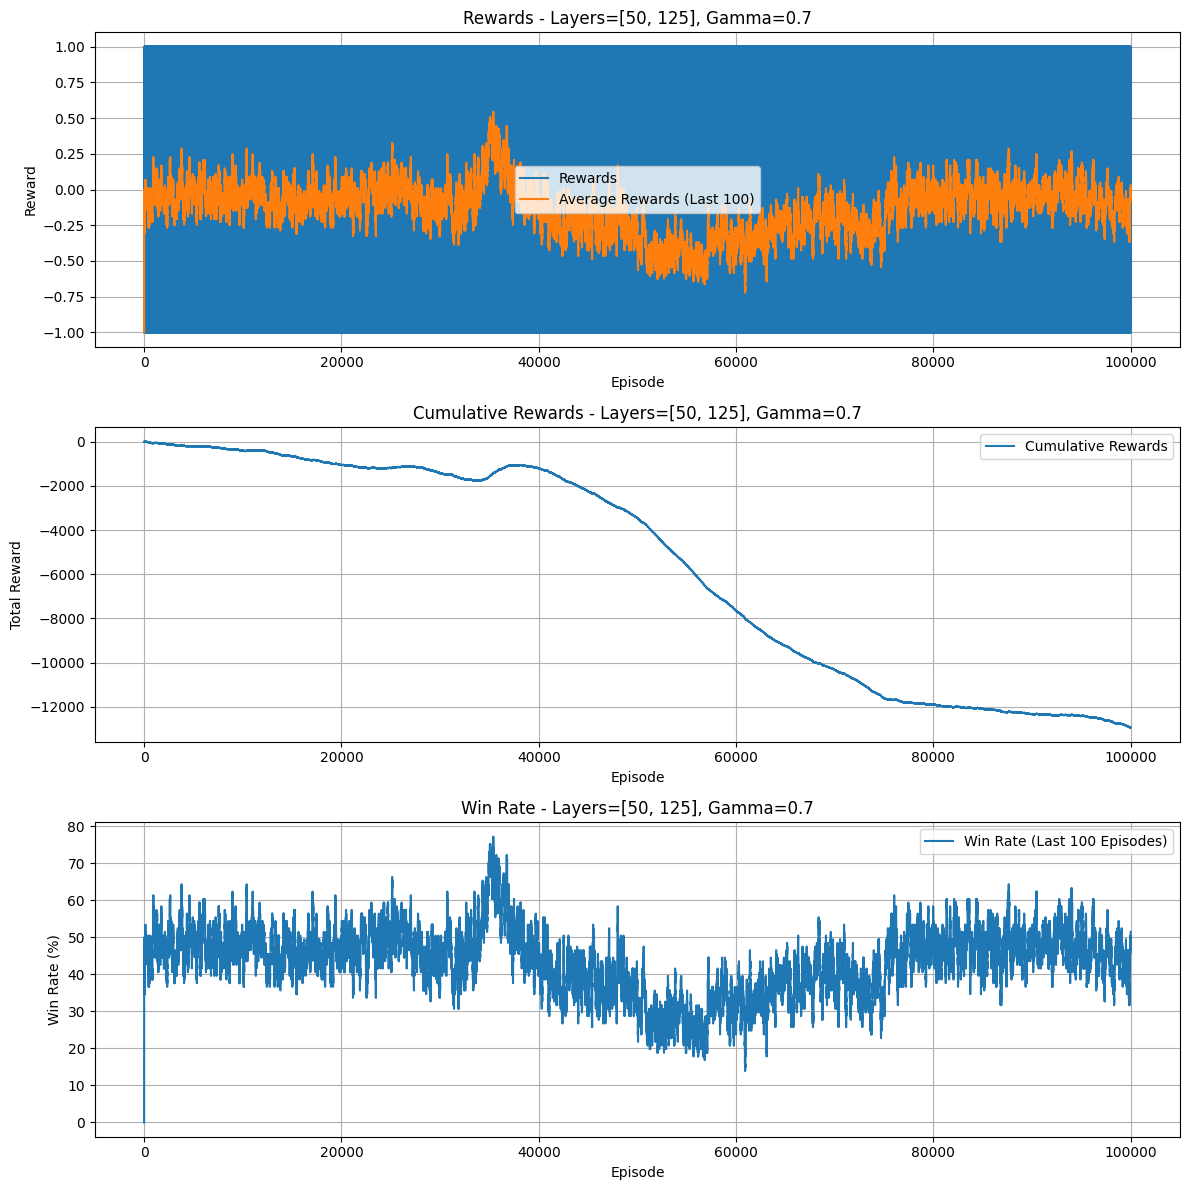

=== Training with LayerStructure=[125, 250, 250, 125] and Gamma=0.95 ===
[10000/100000] Layers=[125, 250, 250, 125], Gamma=0.95, AvgReward(Last100)=0.08, WinRate(Last100)=54.00%, Eps=0.050
[20000/100000] Layers=[125, 250, 250, 125], Gamma=0.95, AvgReward(Last100)=-0.10, WinRate(Last100)=45.00%, Eps=0.050
[30000/100000] Layers=[125, 250, 250, 125], Gamma=0.95, AvgReward(Last100)=-0.70, WinRate(Last100)=15.00%, Eps=0.050
[40000/100000] Layers=[125, 250, 250, 125], Gamma=0.95, AvgReward(Last100)=-0.46, WinRate(Last100)=27.00%, Eps=0.050
[50000/100000] Layers=[125, 250, 250, 125], Gamma=0.95, AvgReward(Last100)=-0.40, WinRate(Last100)=30.00%, Eps=0.050
[60000/100000] Layers=[125, 250, 250, 125], Gamma=0.95, AvgReward(Last100)=-0.40, WinRate(Last100)=30.00%, Eps=0.050
[70000/100000] Layers=[125, 250, 250, 125], Gamma=0.95, AvgReward(Last100)=-0.52, WinRate(Last100)=24.00%, Eps=0.050
[80000/100000] Layers=[125, 250, 250, 125], Gamma=0.95, AvgReward(Last100)=-0.34, WinRate(Last100)=33.00%, Ep

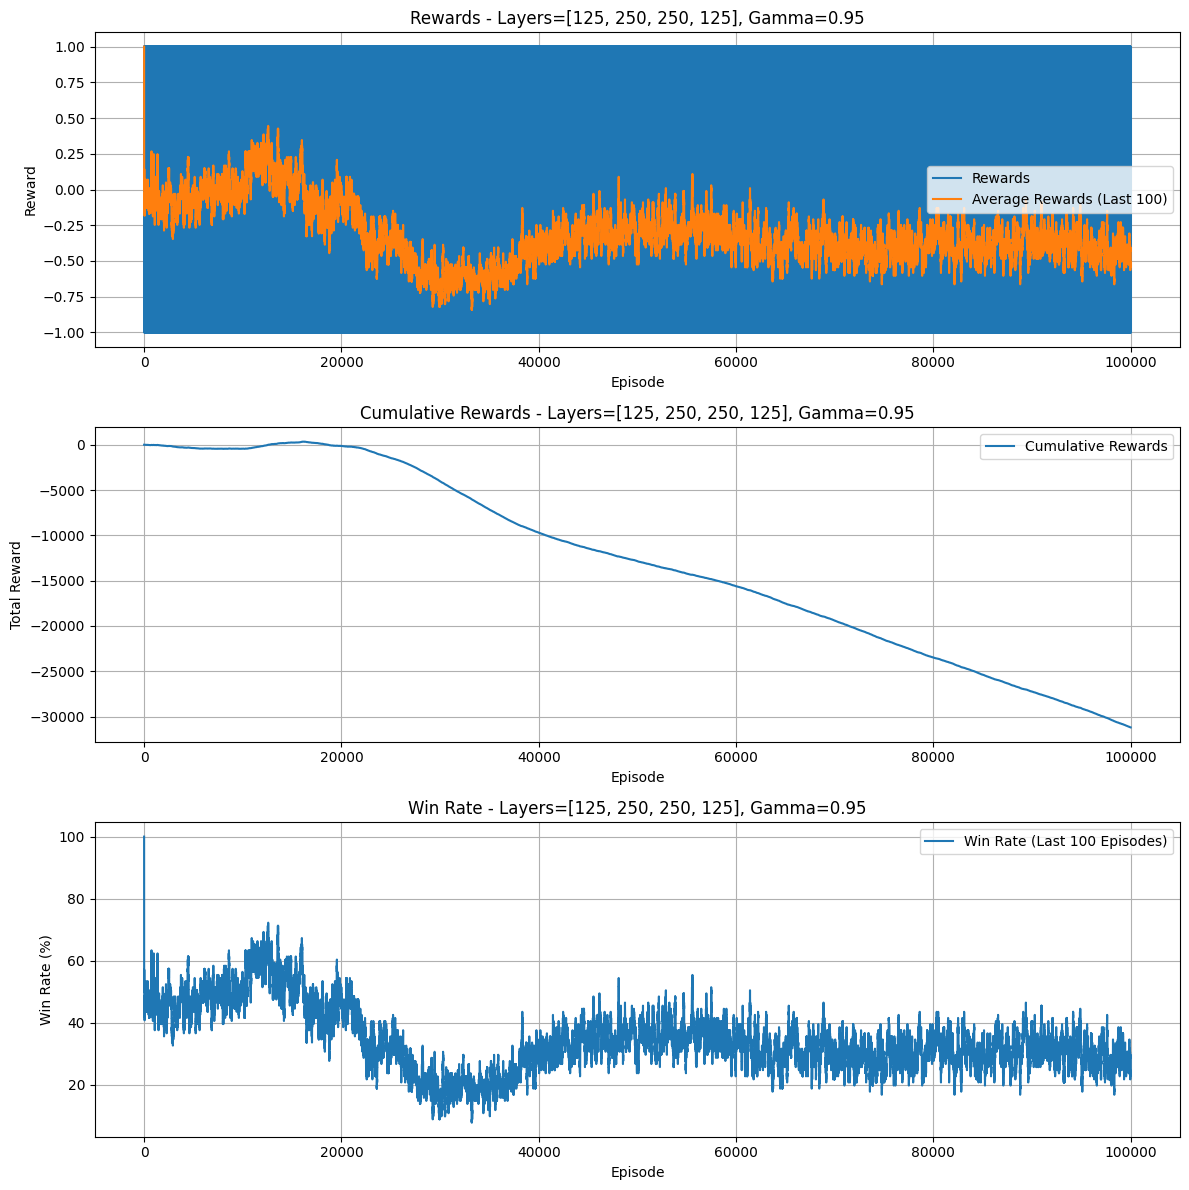

=== Training with LayerStructure=[125, 250, 250, 125] and Gamma=0.9 ===
[10000/100000] Layers=[125, 250, 250, 125], Gamma=0.9, AvgReward(Last100)=-0.30, WinRate(Last100)=35.00%, Eps=0.050
[20000/100000] Layers=[125, 250, 250, 125], Gamma=0.9, AvgReward(Last100)=0.06, WinRate(Last100)=53.00%, Eps=0.050
[30000/100000] Layers=[125, 250, 250, 125], Gamma=0.9, AvgReward(Last100)=0.56, WinRate(Last100)=78.00%, Eps=0.050
[40000/100000] Layers=[125, 250, 250, 125], Gamma=0.9, AvgReward(Last100)=0.48, WinRate(Last100)=74.00%, Eps=0.050
[50000/100000] Layers=[125, 250, 250, 125], Gamma=0.9, AvgReward(Last100)=0.42, WinRate(Last100)=71.00%, Eps=0.050
[60000/100000] Layers=[125, 250, 250, 125], Gamma=0.9, AvgReward(Last100)=0.30, WinRate(Last100)=65.00%, Eps=0.050
[70000/100000] Layers=[125, 250, 250, 125], Gamma=0.9, AvgReward(Last100)=0.32, WinRate(Last100)=66.00%, Eps=0.050
[80000/100000] Layers=[125, 250, 250, 125], Gamma=0.9, AvgReward(Last100)=0.36, WinRate(Last100)=68.00%, Eps=0.050
[90000/

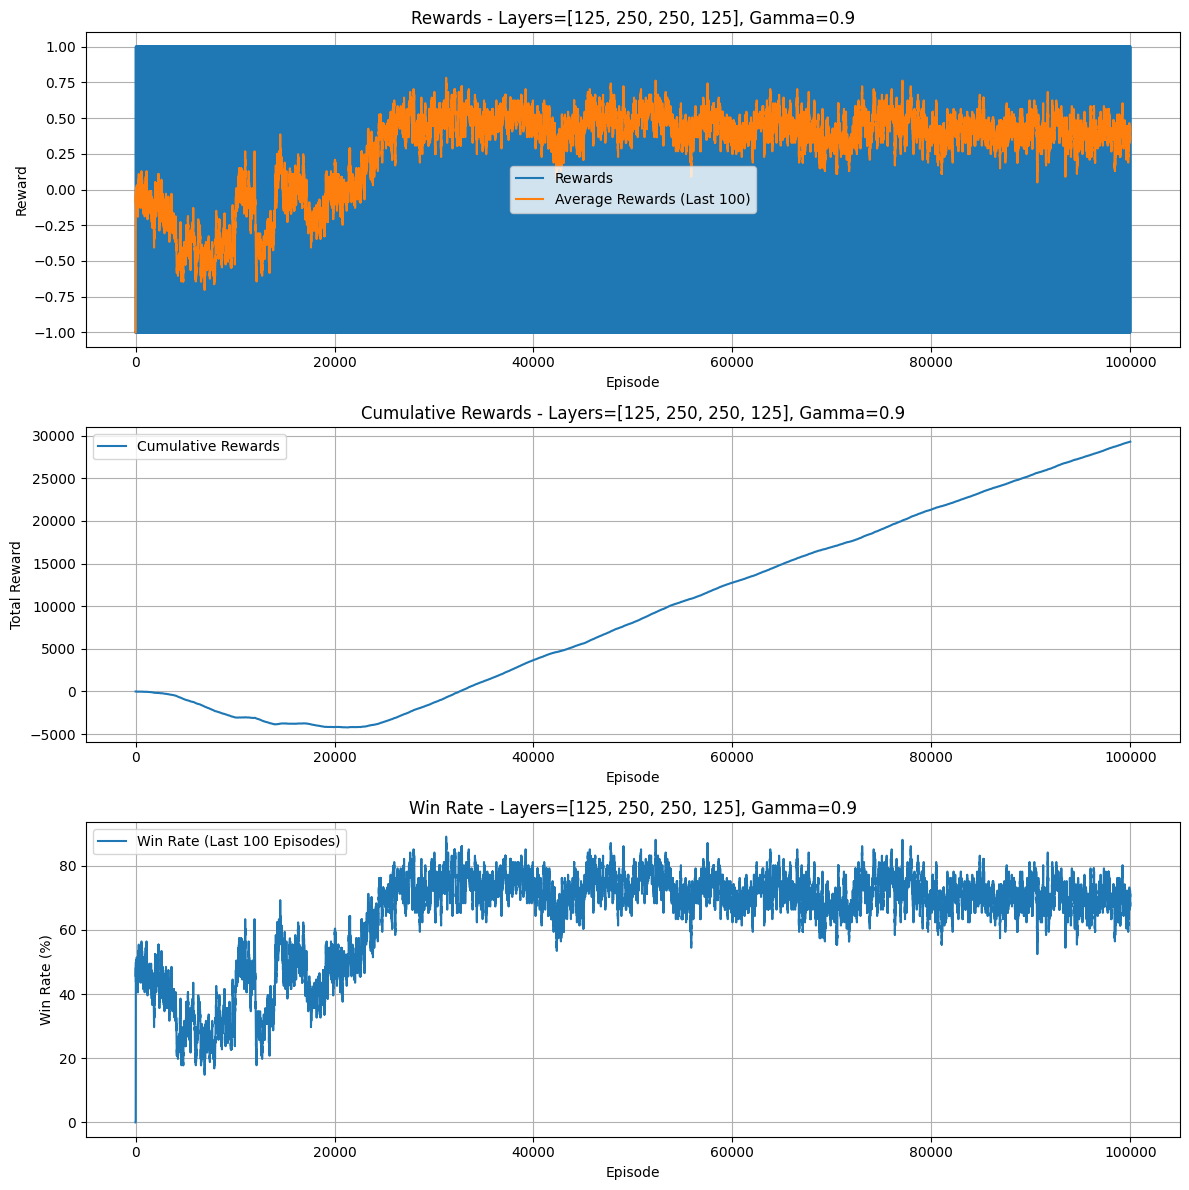

=== Training with LayerStructure=[125, 250, 250, 125] and Gamma=0.85 ===
[10000/100000] Layers=[125, 250, 250, 125], Gamma=0.85, AvgReward(Last100)=-0.54, WinRate(Last100)=23.00%, Eps=0.050
[20000/100000] Layers=[125, 250, 250, 125], Gamma=0.85, AvgReward(Last100)=-0.48, WinRate(Last100)=26.00%, Eps=0.050
[30000/100000] Layers=[125, 250, 250, 125], Gamma=0.85, AvgReward(Last100)=-0.68, WinRate(Last100)=16.00%, Eps=0.050
[40000/100000] Layers=[125, 250, 250, 125], Gamma=0.85, AvgReward(Last100)=-0.72, WinRate(Last100)=14.00%, Eps=0.050
[50000/100000] Layers=[125, 250, 250, 125], Gamma=0.85, AvgReward(Last100)=-0.68, WinRate(Last100)=16.00%, Eps=0.050
[60000/100000] Layers=[125, 250, 250, 125], Gamma=0.85, AvgReward(Last100)=-0.60, WinRate(Last100)=20.00%, Eps=0.050
[70000/100000] Layers=[125, 250, 250, 125], Gamma=0.85, AvgReward(Last100)=-0.60, WinRate(Last100)=20.00%, Eps=0.050
[80000/100000] Layers=[125, 250, 250, 125], Gamma=0.85, AvgReward(Last100)=-0.64, WinRate(Last100)=18.00%, E

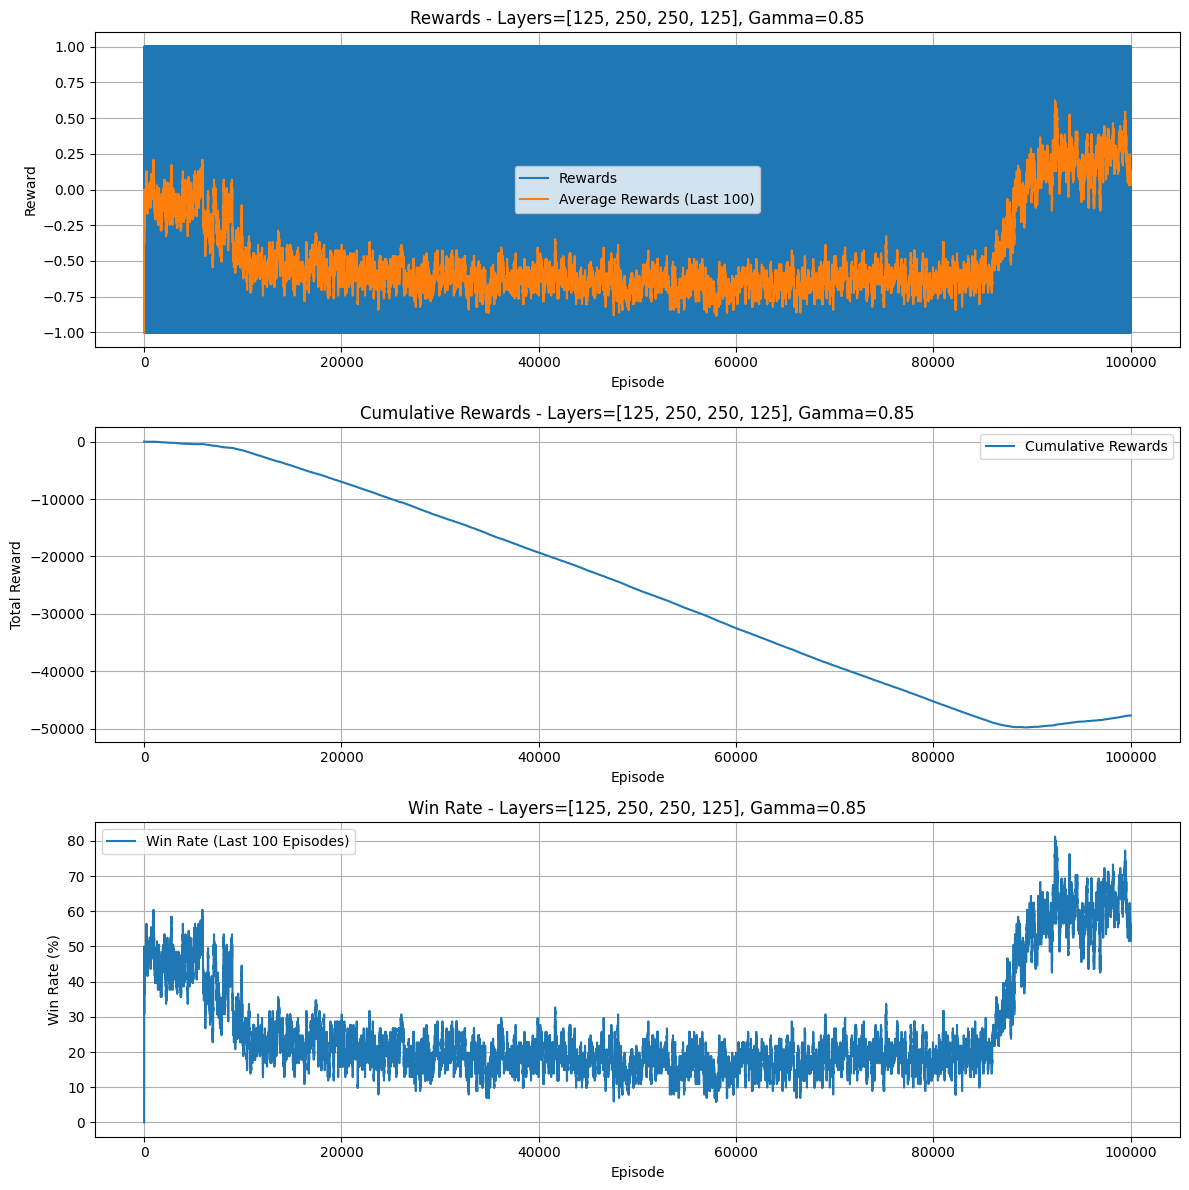

=== Training with LayerStructure=[125, 250, 250, 125] and Gamma=0.8 ===
[10000/100000] Layers=[125, 250, 250, 125], Gamma=0.8, AvgReward(Last100)=-0.08, WinRate(Last100)=46.00%, Eps=0.050
[20000/100000] Layers=[125, 250, 250, 125], Gamma=0.8, AvgReward(Last100)=-0.16, WinRate(Last100)=42.00%, Eps=0.050
[30000/100000] Layers=[125, 250, 250, 125], Gamma=0.8, AvgReward(Last100)=-0.68, WinRate(Last100)=16.00%, Eps=0.050
[40000/100000] Layers=[125, 250, 250, 125], Gamma=0.8, AvgReward(Last100)=-0.56, WinRate(Last100)=22.00%, Eps=0.050
[50000/100000] Layers=[125, 250, 250, 125], Gamma=0.8, AvgReward(Last100)=-0.58, WinRate(Last100)=21.00%, Eps=0.050
[60000/100000] Layers=[125, 250, 250, 125], Gamma=0.8, AvgReward(Last100)=-0.56, WinRate(Last100)=22.00%, Eps=0.050
[70000/100000] Layers=[125, 250, 250, 125], Gamma=0.8, AvgReward(Last100)=-0.54, WinRate(Last100)=23.00%, Eps=0.050
[80000/100000] Layers=[125, 250, 250, 125], Gamma=0.8, AvgReward(Last100)=-0.74, WinRate(Last100)=13.00%, Eps=0.050


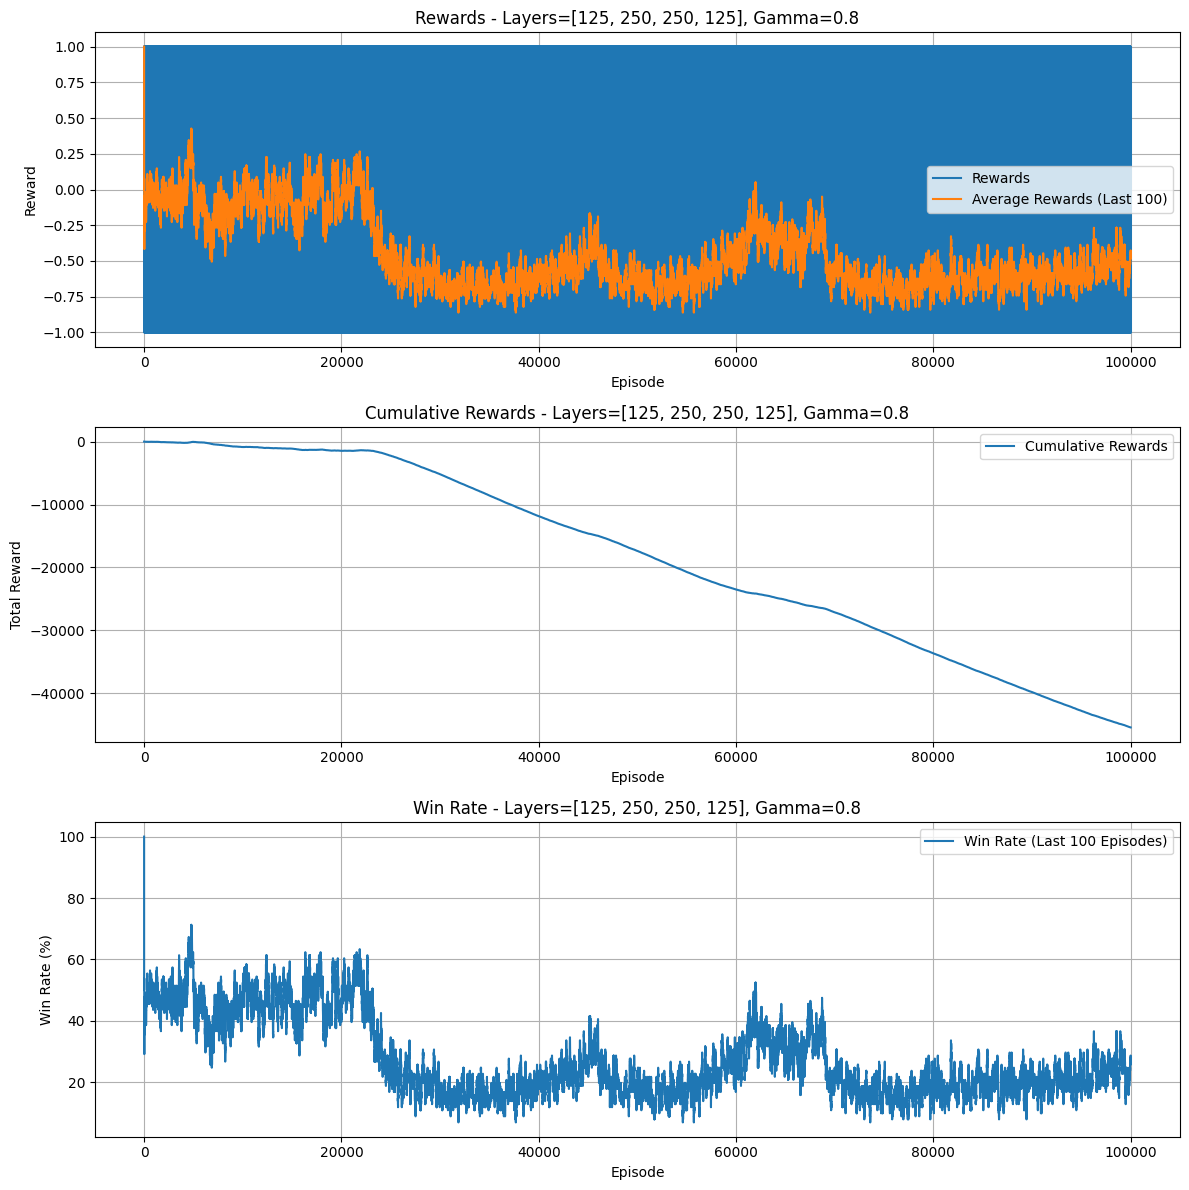

=== Training with LayerStructure=[125, 250, 250, 125] and Gamma=0.75 ===
[10000/100000] Layers=[125, 250, 250, 125], Gamma=0.75, AvgReward(Last100)=-0.04, WinRate(Last100)=48.00%, Eps=0.050
[20000/100000] Layers=[125, 250, 250, 125], Gamma=0.75, AvgReward(Last100)=-0.70, WinRate(Last100)=15.00%, Eps=0.050
[30000/100000] Layers=[125, 250, 250, 125], Gamma=0.75, AvgReward(Last100)=-0.70, WinRate(Last100)=15.00%, Eps=0.050
[40000/100000] Layers=[125, 250, 250, 125], Gamma=0.75, AvgReward(Last100)=-0.58, WinRate(Last100)=21.00%, Eps=0.050
[50000/100000] Layers=[125, 250, 250, 125], Gamma=0.75, AvgReward(Last100)=-0.50, WinRate(Last100)=25.00%, Eps=0.050
[60000/100000] Layers=[125, 250, 250, 125], Gamma=0.75, AvgReward(Last100)=-0.36, WinRate(Last100)=32.00%, Eps=0.050
[70000/100000] Layers=[125, 250, 250, 125], Gamma=0.75, AvgReward(Last100)=-0.32, WinRate(Last100)=34.00%, Eps=0.050
[80000/100000] Layers=[125, 250, 250, 125], Gamma=0.75, AvgReward(Last100)=0.04, WinRate(Last100)=52.00%, Ep

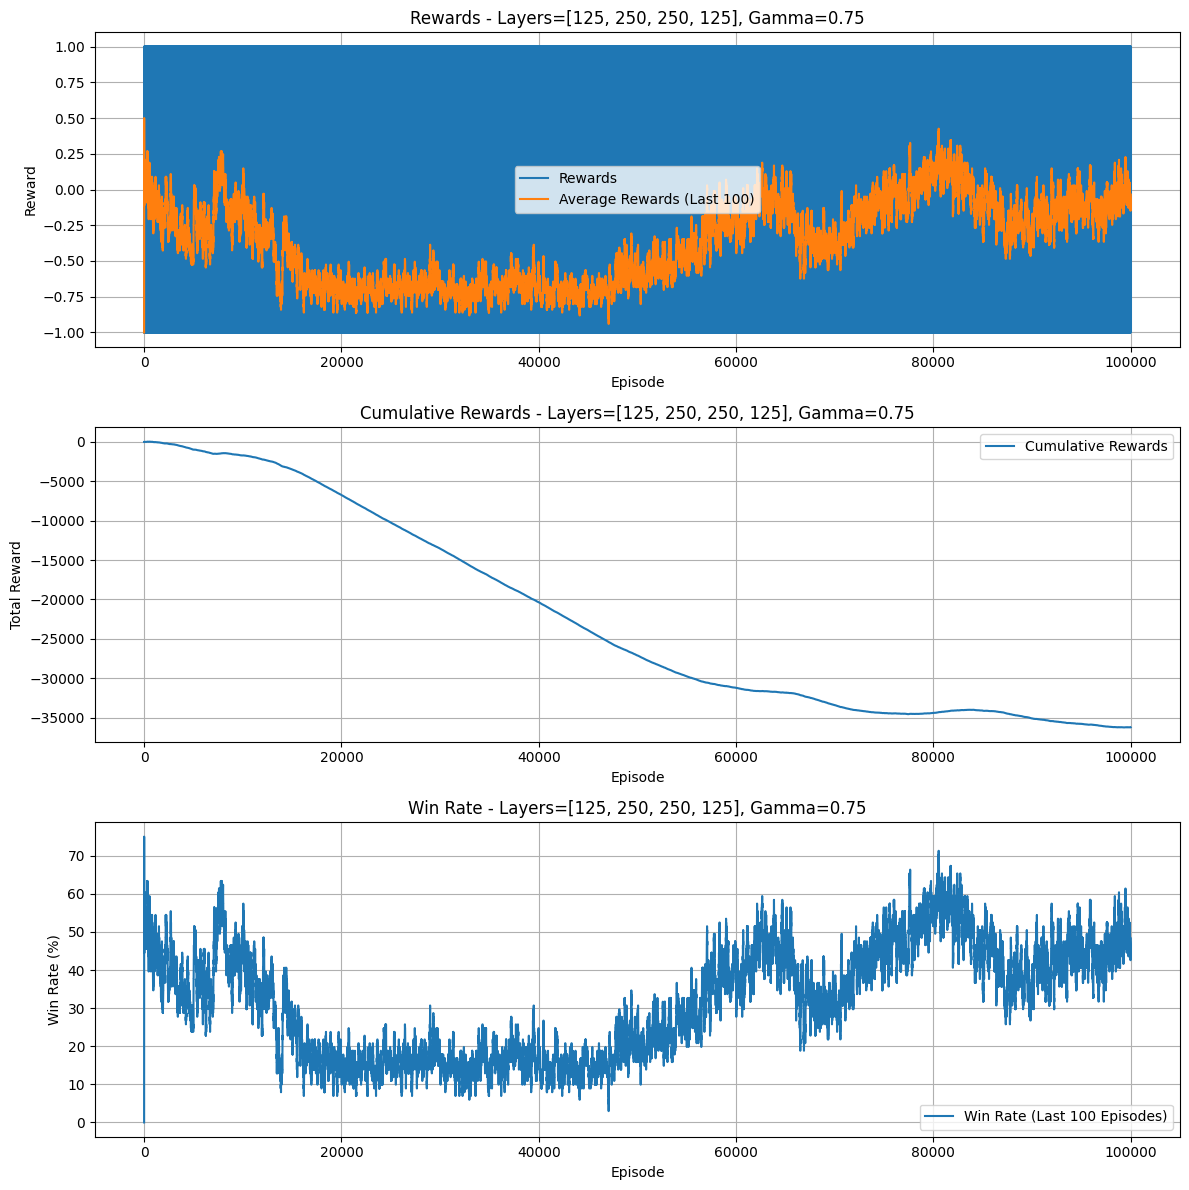

=== Training with LayerStructure=[125, 250, 250, 125] and Gamma=0.7 ===
[10000/100000] Layers=[125, 250, 250, 125], Gamma=0.7, AvgReward(Last100)=-0.22, WinRate(Last100)=39.00%, Eps=0.050
[20000/100000] Layers=[125, 250, 250, 125], Gamma=0.7, AvgReward(Last100)=-0.60, WinRate(Last100)=20.00%, Eps=0.050
[30000/100000] Layers=[125, 250, 250, 125], Gamma=0.7, AvgReward(Last100)=-0.76, WinRate(Last100)=12.00%, Eps=0.050
[40000/100000] Layers=[125, 250, 250, 125], Gamma=0.7, AvgReward(Last100)=-0.56, WinRate(Last100)=22.00%, Eps=0.050
[50000/100000] Layers=[125, 250, 250, 125], Gamma=0.7, AvgReward(Last100)=0.12, WinRate(Last100)=56.00%, Eps=0.050
[60000/100000] Layers=[125, 250, 250, 125], Gamma=0.7, AvgReward(Last100)=0.30, WinRate(Last100)=65.00%, Eps=0.050
[70000/100000] Layers=[125, 250, 250, 125], Gamma=0.7, AvgReward(Last100)=0.26, WinRate(Last100)=63.00%, Eps=0.050
[80000/100000] Layers=[125, 250, 250, 125], Gamma=0.7, AvgReward(Last100)=0.52, WinRate(Last100)=76.00%, Eps=0.050
[900

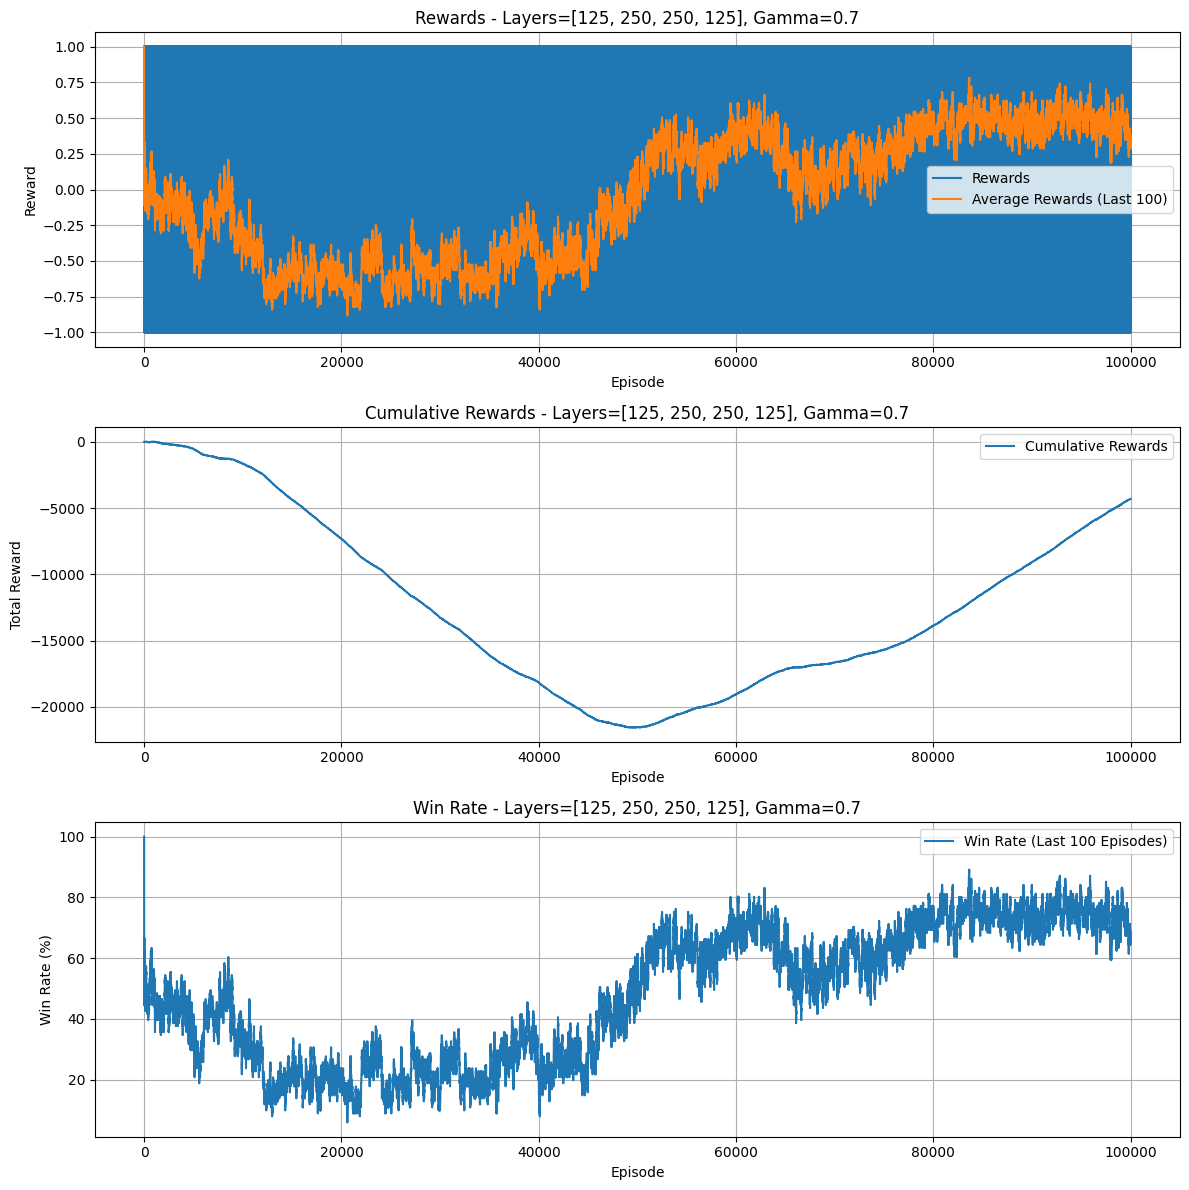

=== Training with LayerStructure=[50, 100, 125] and Gamma=0.95 ===
[10000/100000] Layers=[50, 100, 125], Gamma=0.95, AvgReward(Last100)=0.08, WinRate(Last100)=54.00%, Eps=0.050
[20000/100000] Layers=[50, 100, 125], Gamma=0.95, AvgReward(Last100)=-0.34, WinRate(Last100)=33.00%, Eps=0.050
[30000/100000] Layers=[50, 100, 125], Gamma=0.95, AvgReward(Last100)=0.38, WinRate(Last100)=69.00%, Eps=0.050
[40000/100000] Layers=[50, 100, 125], Gamma=0.95, AvgReward(Last100)=0.20, WinRate(Last100)=60.00%, Eps=0.050
[50000/100000] Layers=[50, 100, 125], Gamma=0.95, AvgReward(Last100)=0.20, WinRate(Last100)=60.00%, Eps=0.050
[60000/100000] Layers=[50, 100, 125], Gamma=0.95, AvgReward(Last100)=-0.48, WinRate(Last100)=26.00%, Eps=0.050
[70000/100000] Layers=[50, 100, 125], Gamma=0.95, AvgReward(Last100)=-0.40, WinRate(Last100)=30.00%, Eps=0.050
[80000/100000] Layers=[50, 100, 125], Gamma=0.95, AvgReward(Last100)=-0.44, WinRate(Last100)=28.00%, Eps=0.050
[90000/100000] Layers=[50, 100, 125], Gamma=0.95,

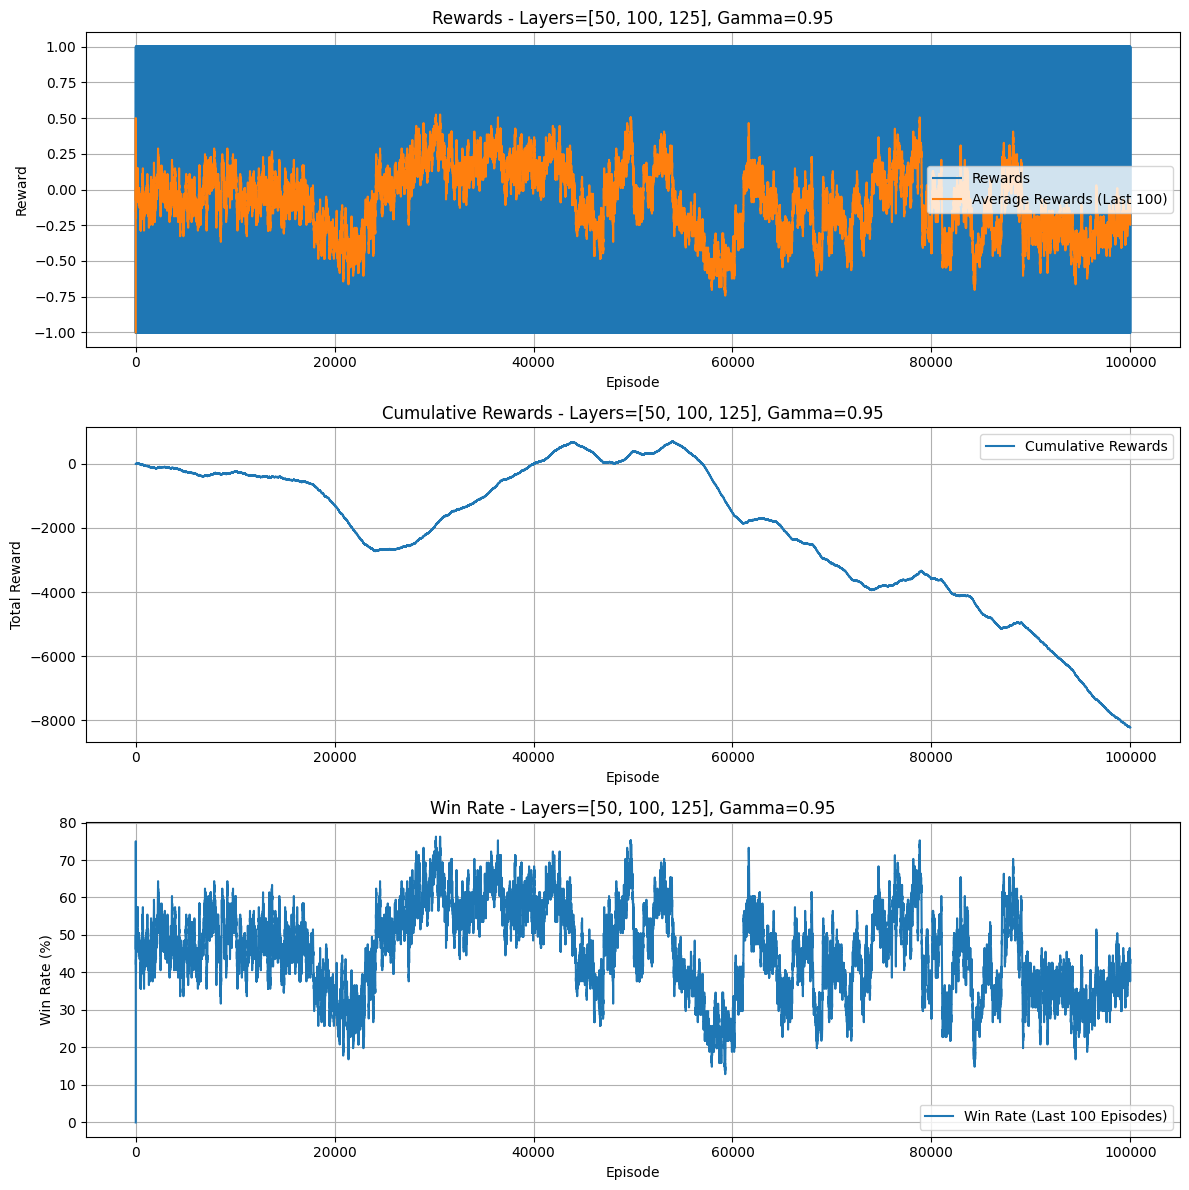

=== Training with LayerStructure=[50, 100, 125] and Gamma=0.9 ===
[10000/100000] Layers=[50, 100, 125], Gamma=0.9, AvgReward(Last100)=-0.04, WinRate(Last100)=48.00%, Eps=0.050
[20000/100000] Layers=[50, 100, 125], Gamma=0.9, AvgReward(Last100)=0.06, WinRate(Last100)=53.00%, Eps=0.050
[30000/100000] Layers=[50, 100, 125], Gamma=0.9, AvgReward(Last100)=0.34, WinRate(Last100)=67.00%, Eps=0.050
[40000/100000] Layers=[50, 100, 125], Gamma=0.9, AvgReward(Last100)=-0.40, WinRate(Last100)=30.00%, Eps=0.050
[50000/100000] Layers=[50, 100, 125], Gamma=0.9, AvgReward(Last100)=0.12, WinRate(Last100)=56.00%, Eps=0.050
[60000/100000] Layers=[50, 100, 125], Gamma=0.9, AvgReward(Last100)=0.14, WinRate(Last100)=57.00%, Eps=0.050
[70000/100000] Layers=[50, 100, 125], Gamma=0.9, AvgReward(Last100)=0.18, WinRate(Last100)=59.00%, Eps=0.050
[80000/100000] Layers=[50, 100, 125], Gamma=0.9, AvgReward(Last100)=0.30, WinRate(Last100)=65.00%, Eps=0.050
[90000/100000] Layers=[50, 100, 125], Gamma=0.9, AvgReward(L

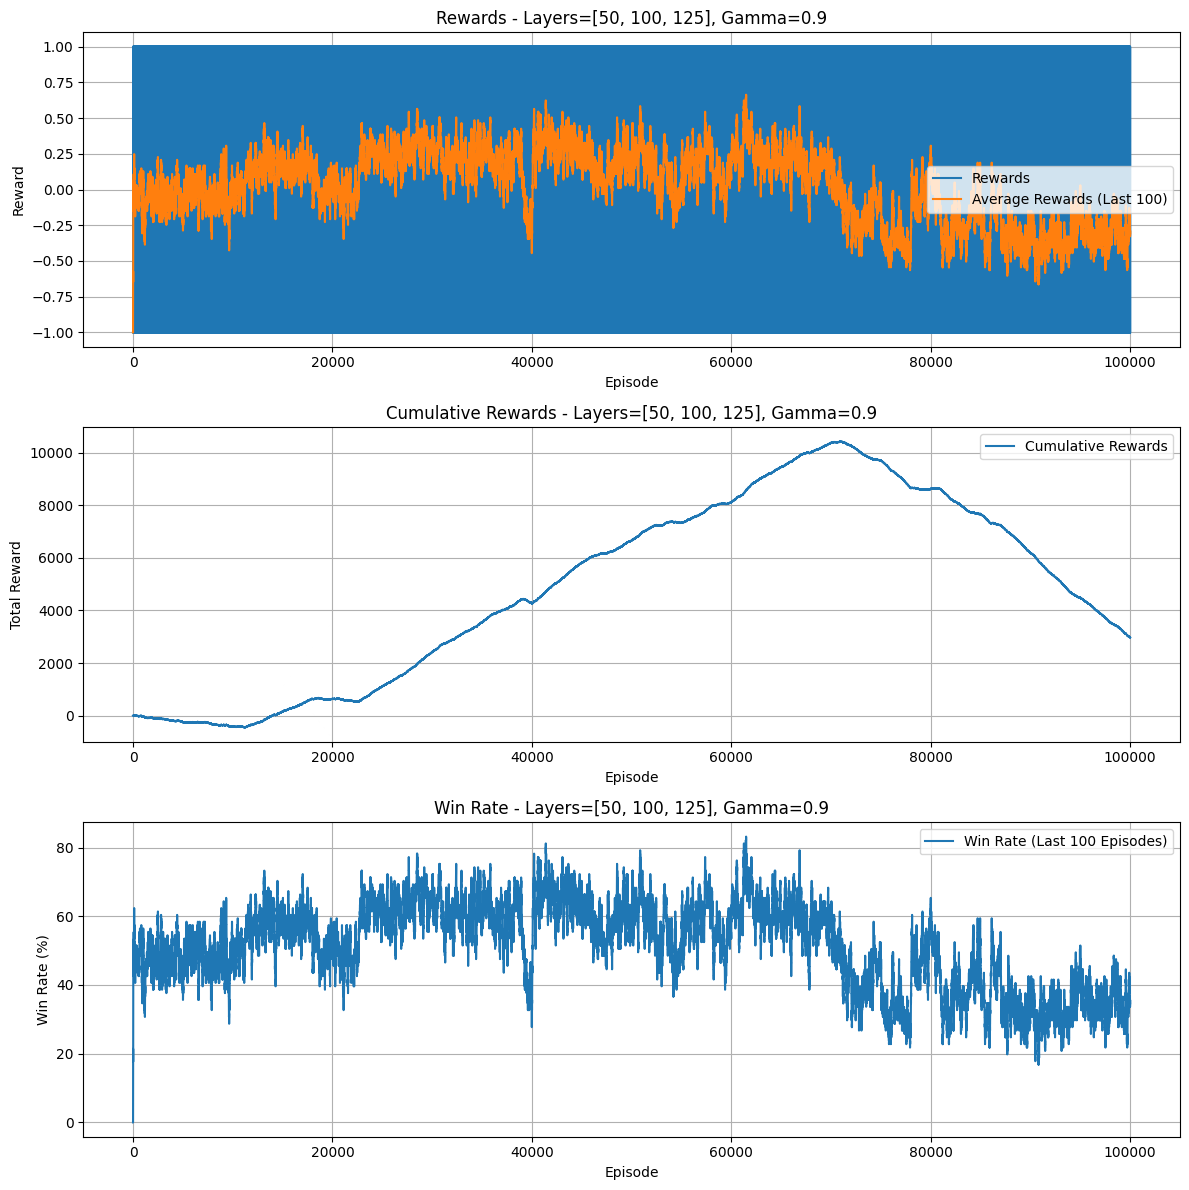

=== Training with LayerStructure=[50, 100, 125] and Gamma=0.85 ===
[10000/100000] Layers=[50, 100, 125], Gamma=0.85, AvgReward(Last100)=-0.02, WinRate(Last100)=49.00%, Eps=0.050
[20000/100000] Layers=[50, 100, 125], Gamma=0.85, AvgReward(Last100)=0.30, WinRate(Last100)=65.00%, Eps=0.050
[30000/100000] Layers=[50, 100, 125], Gamma=0.85, AvgReward(Last100)=0.24, WinRate(Last100)=62.00%, Eps=0.050
[40000/100000] Layers=[50, 100, 125], Gamma=0.85, AvgReward(Last100)=0.32, WinRate(Last100)=66.00%, Eps=0.050
[50000/100000] Layers=[50, 100, 125], Gamma=0.85, AvgReward(Last100)=0.24, WinRate(Last100)=62.00%, Eps=0.050
[60000/100000] Layers=[50, 100, 125], Gamma=0.85, AvgReward(Last100)=-0.02, WinRate(Last100)=49.00%, Eps=0.050
[70000/100000] Layers=[50, 100, 125], Gamma=0.85, AvgReward(Last100)=0.12, WinRate(Last100)=56.00%, Eps=0.050
[80000/100000] Layers=[50, 100, 125], Gamma=0.85, AvgReward(Last100)=-0.14, WinRate(Last100)=43.00%, Eps=0.050
[90000/100000] Layers=[50, 100, 125], Gamma=0.85, 

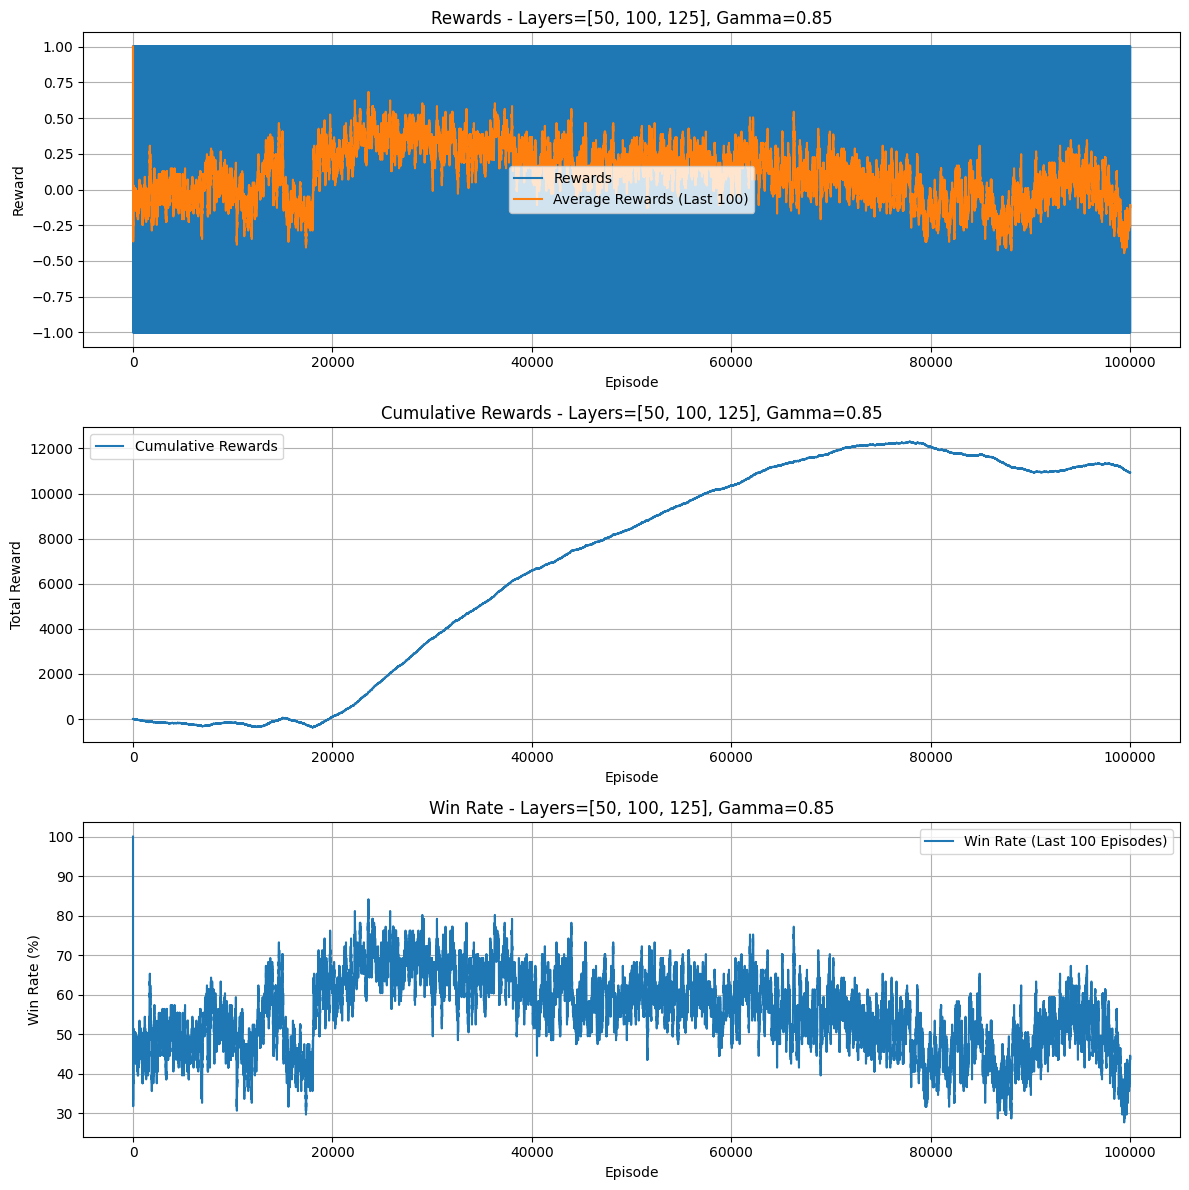

=== Training with LayerStructure=[50, 100, 125] and Gamma=0.8 ===
[10000/100000] Layers=[50, 100, 125], Gamma=0.8, AvgReward(Last100)=0.28, WinRate(Last100)=64.00%, Eps=0.050
[20000/100000] Layers=[50, 100, 125], Gamma=0.8, AvgReward(Last100)=0.20, WinRate(Last100)=60.00%, Eps=0.050
[30000/100000] Layers=[50, 100, 125], Gamma=0.8, AvgReward(Last100)=0.42, WinRate(Last100)=71.00%, Eps=0.050
[40000/100000] Layers=[50, 100, 125], Gamma=0.8, AvgReward(Last100)=0.62, WinRate(Last100)=81.00%, Eps=0.050
[50000/100000] Layers=[50, 100, 125], Gamma=0.8, AvgReward(Last100)=0.46, WinRate(Last100)=73.00%, Eps=0.050
[60000/100000] Layers=[50, 100, 125], Gamma=0.8, AvgReward(Last100)=0.46, WinRate(Last100)=73.00%, Eps=0.050
[70000/100000] Layers=[50, 100, 125], Gamma=0.8, AvgReward(Last100)=0.46, WinRate(Last100)=73.00%, Eps=0.050
[80000/100000] Layers=[50, 100, 125], Gamma=0.8, AvgReward(Last100)=0.52, WinRate(Last100)=76.00%, Eps=0.050
[90000/100000] Layers=[50, 100, 125], Gamma=0.8, AvgReward(Las

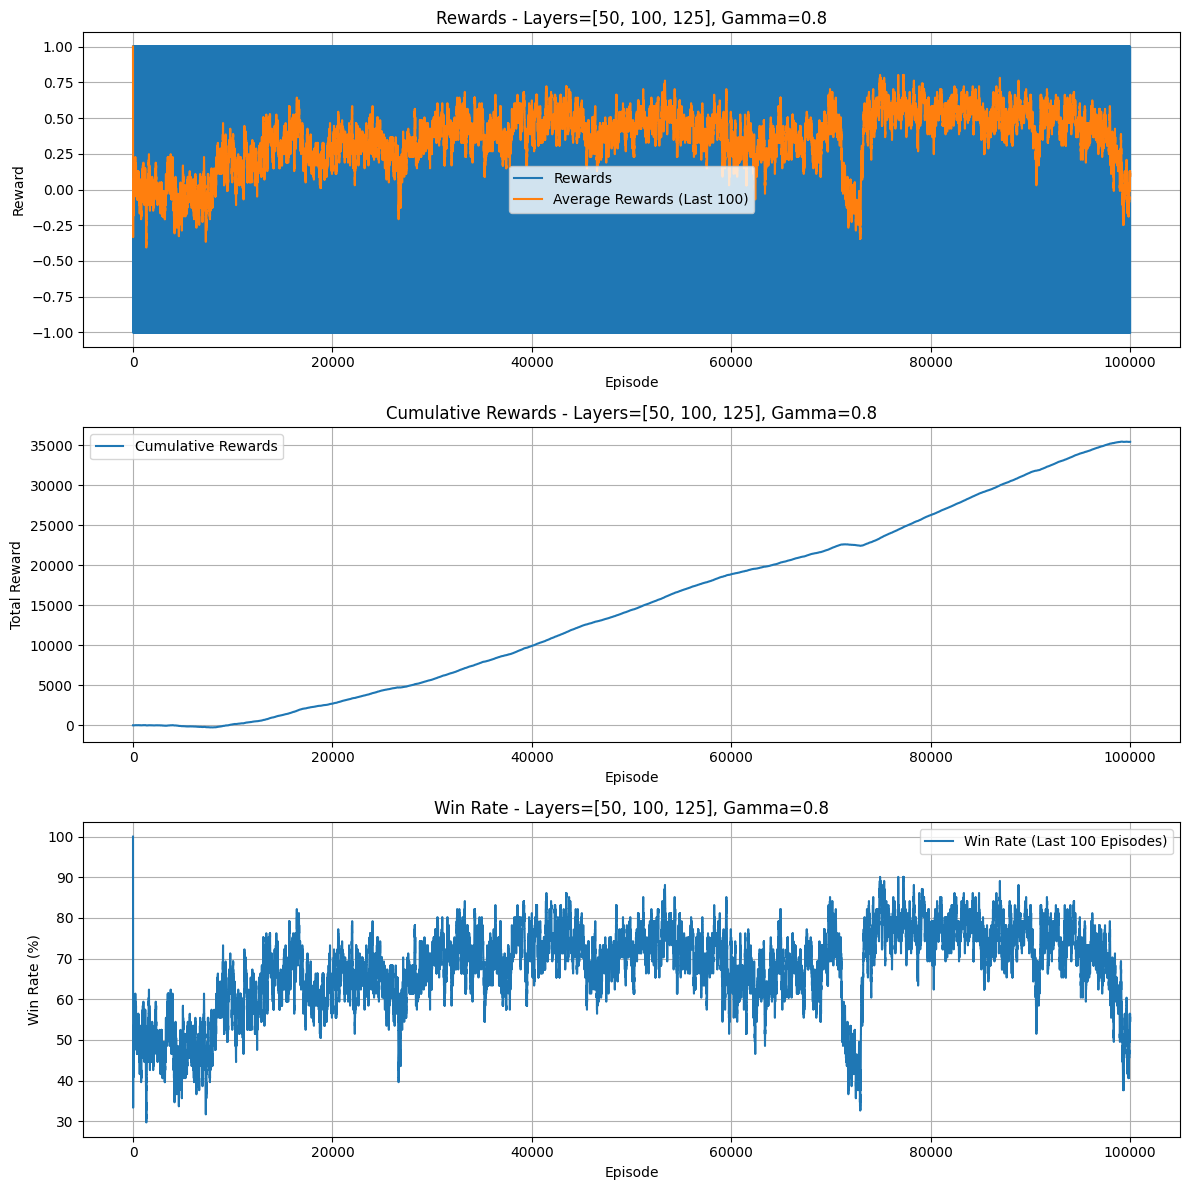

=== Training with LayerStructure=[50, 100, 125] and Gamma=0.75 ===
[10000/100000] Layers=[50, 100, 125], Gamma=0.75, AvgReward(Last100)=0.40, WinRate(Last100)=70.00%, Eps=0.050
[20000/100000] Layers=[50, 100, 125], Gamma=0.75, AvgReward(Last100)=-0.12, WinRate(Last100)=44.00%, Eps=0.050
[30000/100000] Layers=[50, 100, 125], Gamma=0.75, AvgReward(Last100)=-0.52, WinRate(Last100)=24.00%, Eps=0.050
[40000/100000] Layers=[50, 100, 125], Gamma=0.75, AvgReward(Last100)=-0.62, WinRate(Last100)=19.00%, Eps=0.050
[50000/100000] Layers=[50, 100, 125], Gamma=0.75, AvgReward(Last100)=-0.62, WinRate(Last100)=19.00%, Eps=0.050
[60000/100000] Layers=[50, 100, 125], Gamma=0.75, AvgReward(Last100)=-0.72, WinRate(Last100)=14.00%, Eps=0.050
[70000/100000] Layers=[50, 100, 125], Gamma=0.75, AvgReward(Last100)=-0.48, WinRate(Last100)=26.00%, Eps=0.050
[80000/100000] Layers=[50, 100, 125], Gamma=0.75, AvgReward(Last100)=-0.08, WinRate(Last100)=46.00%, Eps=0.050
[90000/100000] Layers=[50, 100, 125], Gamma=0.

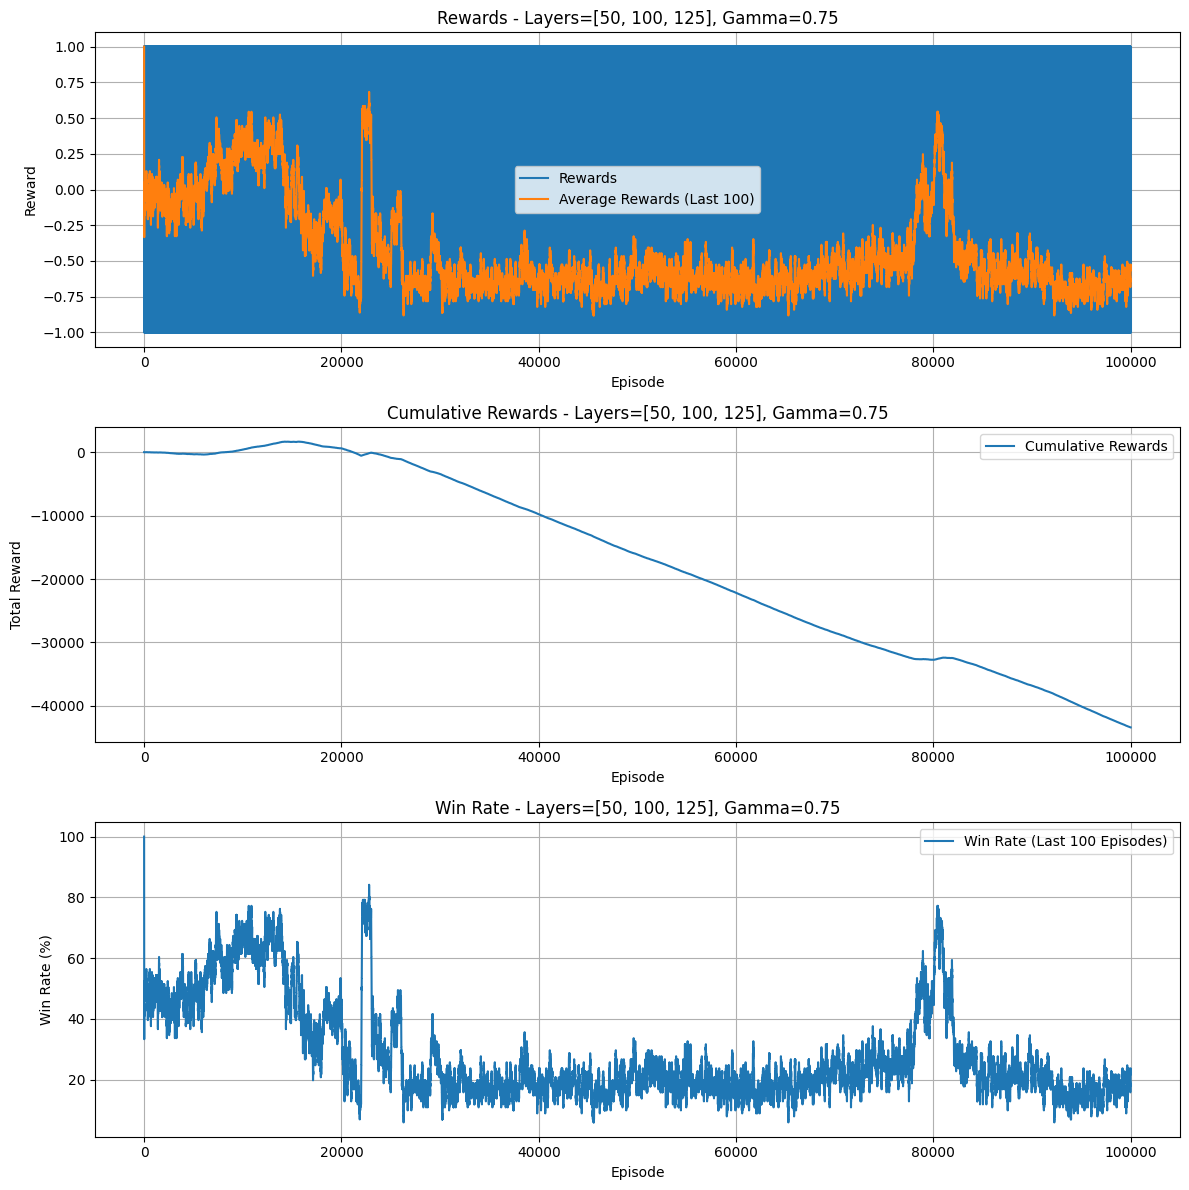

=== Training with LayerStructure=[50, 100, 125] and Gamma=0.7 ===
[10000/100000] Layers=[50, 100, 125], Gamma=0.7, AvgReward(Last100)=0.16, WinRate(Last100)=58.00%, Eps=0.050
[20000/100000] Layers=[50, 100, 125], Gamma=0.7, AvgReward(Last100)=0.44, WinRate(Last100)=72.00%, Eps=0.050
[30000/100000] Layers=[50, 100, 125], Gamma=0.7, AvgReward(Last100)=0.46, WinRate(Last100)=73.00%, Eps=0.050
[40000/100000] Layers=[50, 100, 125], Gamma=0.7, AvgReward(Last100)=0.40, WinRate(Last100)=70.00%, Eps=0.050
[50000/100000] Layers=[50, 100, 125], Gamma=0.7, AvgReward(Last100)=0.56, WinRate(Last100)=78.00%, Eps=0.050
[60000/100000] Layers=[50, 100, 125], Gamma=0.7, AvgReward(Last100)=0.44, WinRate(Last100)=72.00%, Eps=0.050
[70000/100000] Layers=[50, 100, 125], Gamma=0.7, AvgReward(Last100)=-0.12, WinRate(Last100)=44.00%, Eps=0.050
[80000/100000] Layers=[50, 100, 125], Gamma=0.7, AvgReward(Last100)=-0.12, WinRate(Last100)=44.00%, Eps=0.050
[90000/100000] Layers=[50, 100, 125], Gamma=0.7, AvgReward(L

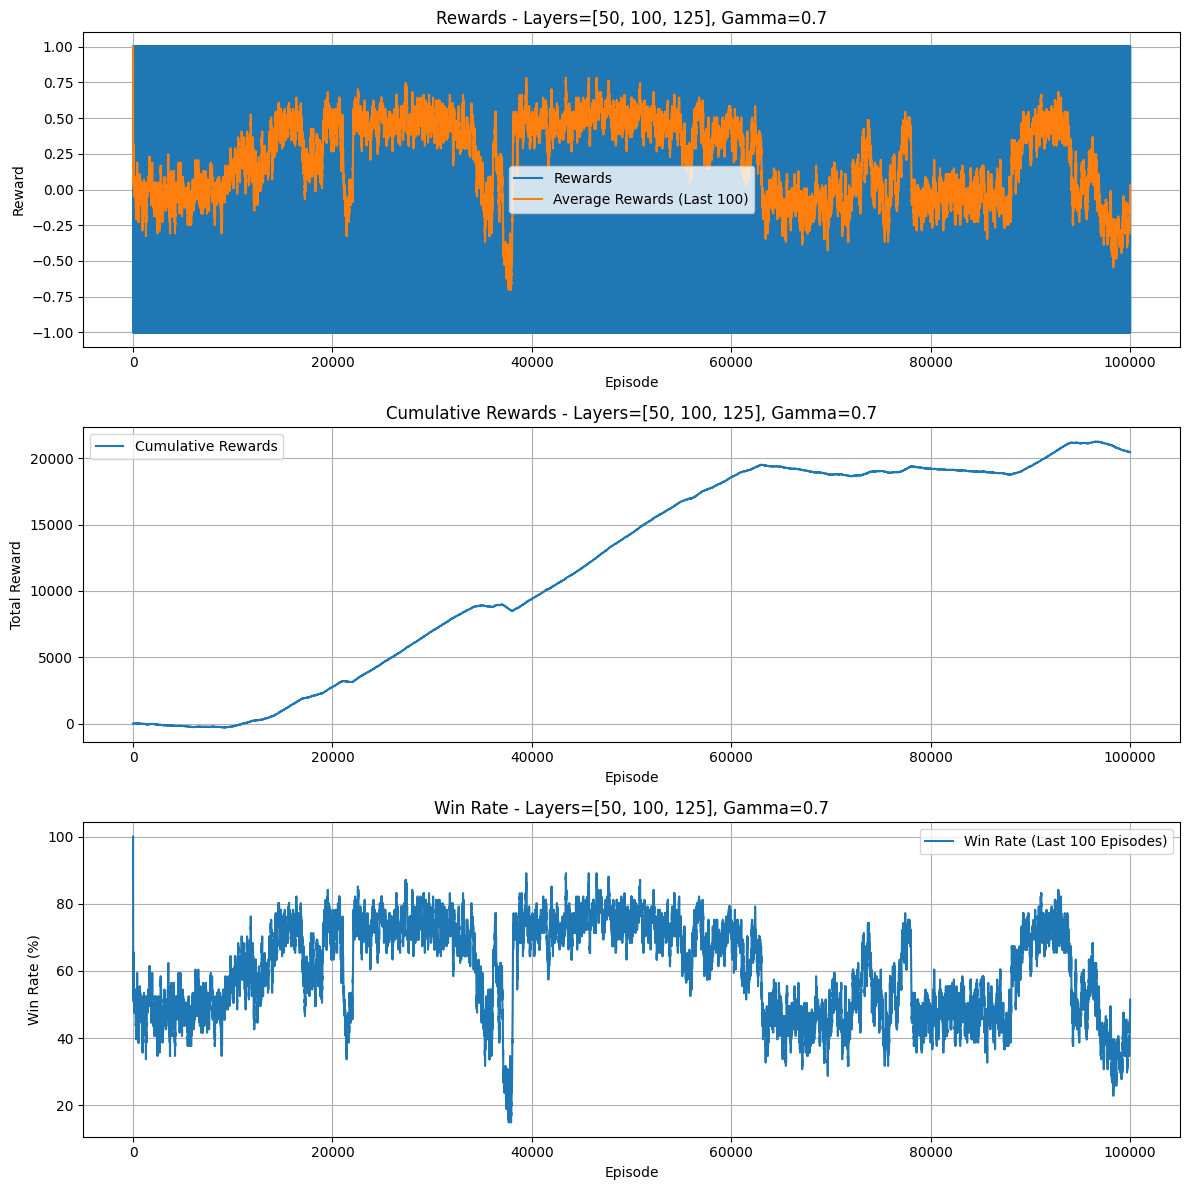

=== Training with LayerStructure=[125, 250] and Gamma=0.95 ===
[10000/100000] Layers=[125, 250], Gamma=0.95, AvgReward(Last100)=0.02, WinRate(Last100)=51.00%, Eps=0.053
[20000/100000] Layers=[125, 250], Gamma=0.95, AvgReward(Last100)=-0.18, WinRate(Last100)=41.00%, Eps=0.050
[30000/100000] Layers=[125, 250], Gamma=0.95, AvgReward(Last100)=0.06, WinRate(Last100)=53.00%, Eps=0.050
[40000/100000] Layers=[125, 250], Gamma=0.95, AvgReward(Last100)=0.18, WinRate(Last100)=59.00%, Eps=0.050
[50000/100000] Layers=[125, 250], Gamma=0.95, AvgReward(Last100)=-0.02, WinRate(Last100)=49.00%, Eps=0.050
[60000/100000] Layers=[125, 250], Gamma=0.95, AvgReward(Last100)=-0.08, WinRate(Last100)=46.00%, Eps=0.050
[70000/100000] Layers=[125, 250], Gamma=0.95, AvgReward(Last100)=-0.16, WinRate(Last100)=42.00%, Eps=0.050
[80000/100000] Layers=[125, 250], Gamma=0.95, AvgReward(Last100)=0.06, WinRate(Last100)=53.00%, Eps=0.050
[90000/100000] Layers=[125, 250], Gamma=0.95, AvgReward(Last100)=0.14, WinRate(Last10

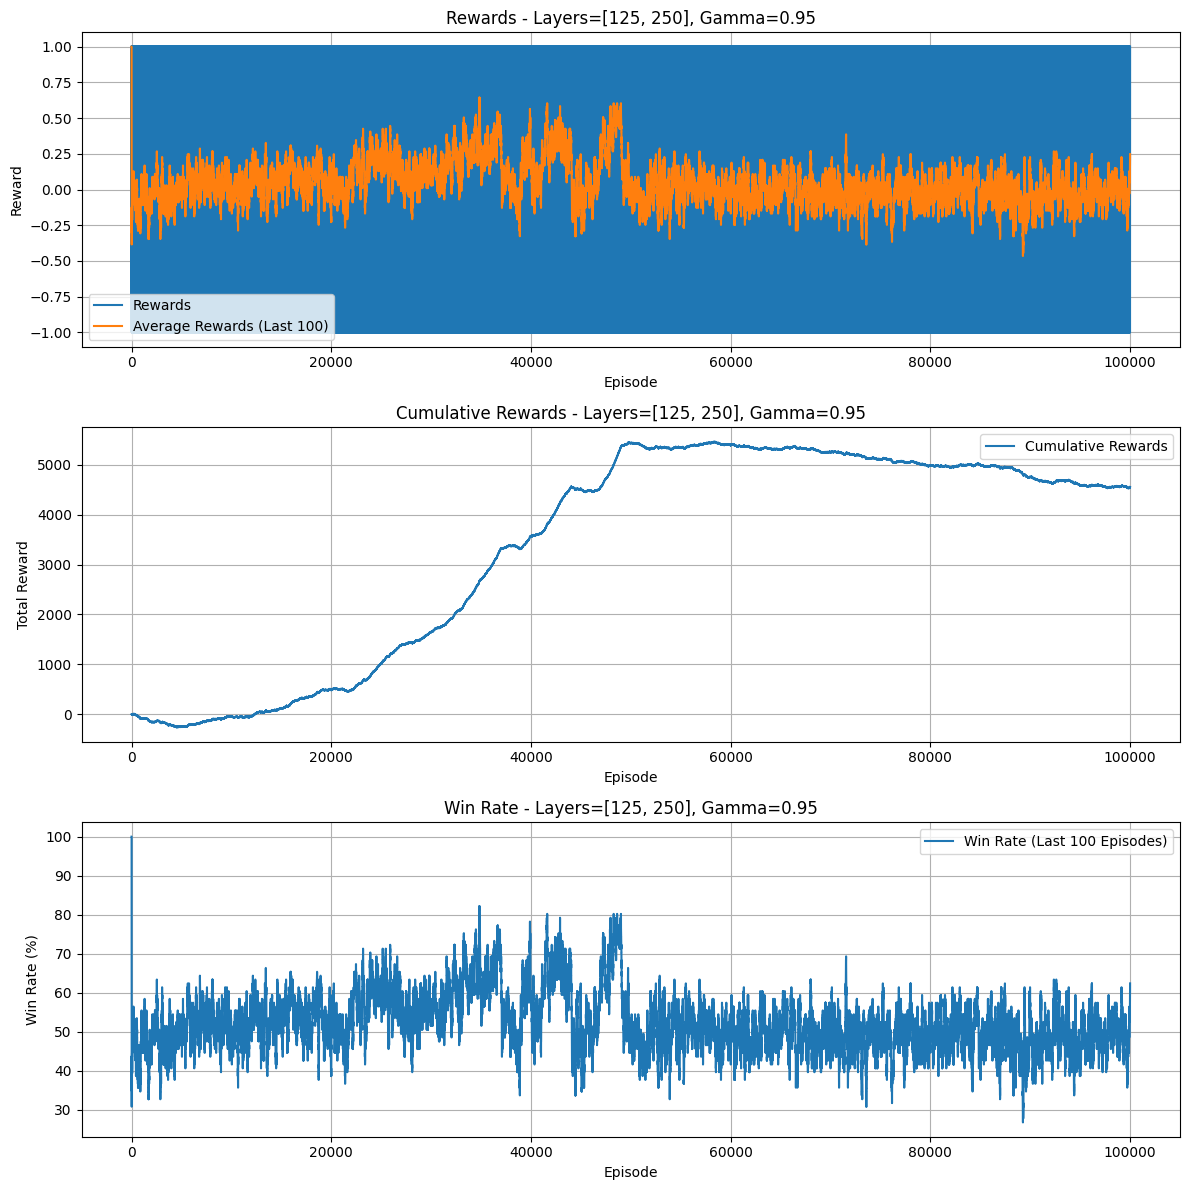

=== Training with LayerStructure=[125, 250] and Gamma=0.9 ===
[10000/100000] Layers=[125, 250], Gamma=0.9, AvgReward(Last100)=0.20, WinRate(Last100)=60.00%, Eps=0.050
[20000/100000] Layers=[125, 250], Gamma=0.9, AvgReward(Last100)=-0.08, WinRate(Last100)=46.00%, Eps=0.050
[30000/100000] Layers=[125, 250], Gamma=0.9, AvgReward(Last100)=0.02, WinRate(Last100)=51.00%, Eps=0.050
[40000/100000] Layers=[125, 250], Gamma=0.9, AvgReward(Last100)=-0.10, WinRate(Last100)=45.00%, Eps=0.050
[50000/100000] Layers=[125, 250], Gamma=0.9, AvgReward(Last100)=0.10, WinRate(Last100)=55.00%, Eps=0.050
[60000/100000] Layers=[125, 250], Gamma=0.9, AvgReward(Last100)=0.00, WinRate(Last100)=50.00%, Eps=0.050
[70000/100000] Layers=[125, 250], Gamma=0.9, AvgReward(Last100)=-0.04, WinRate(Last100)=48.00%, Eps=0.050
[80000/100000] Layers=[125, 250], Gamma=0.9, AvgReward(Last100)=0.12, WinRate(Last100)=56.00%, Eps=0.050
[90000/100000] Layers=[125, 250], Gamma=0.9, AvgReward(Last100)=-0.04, WinRate(Last100)=48.00%,

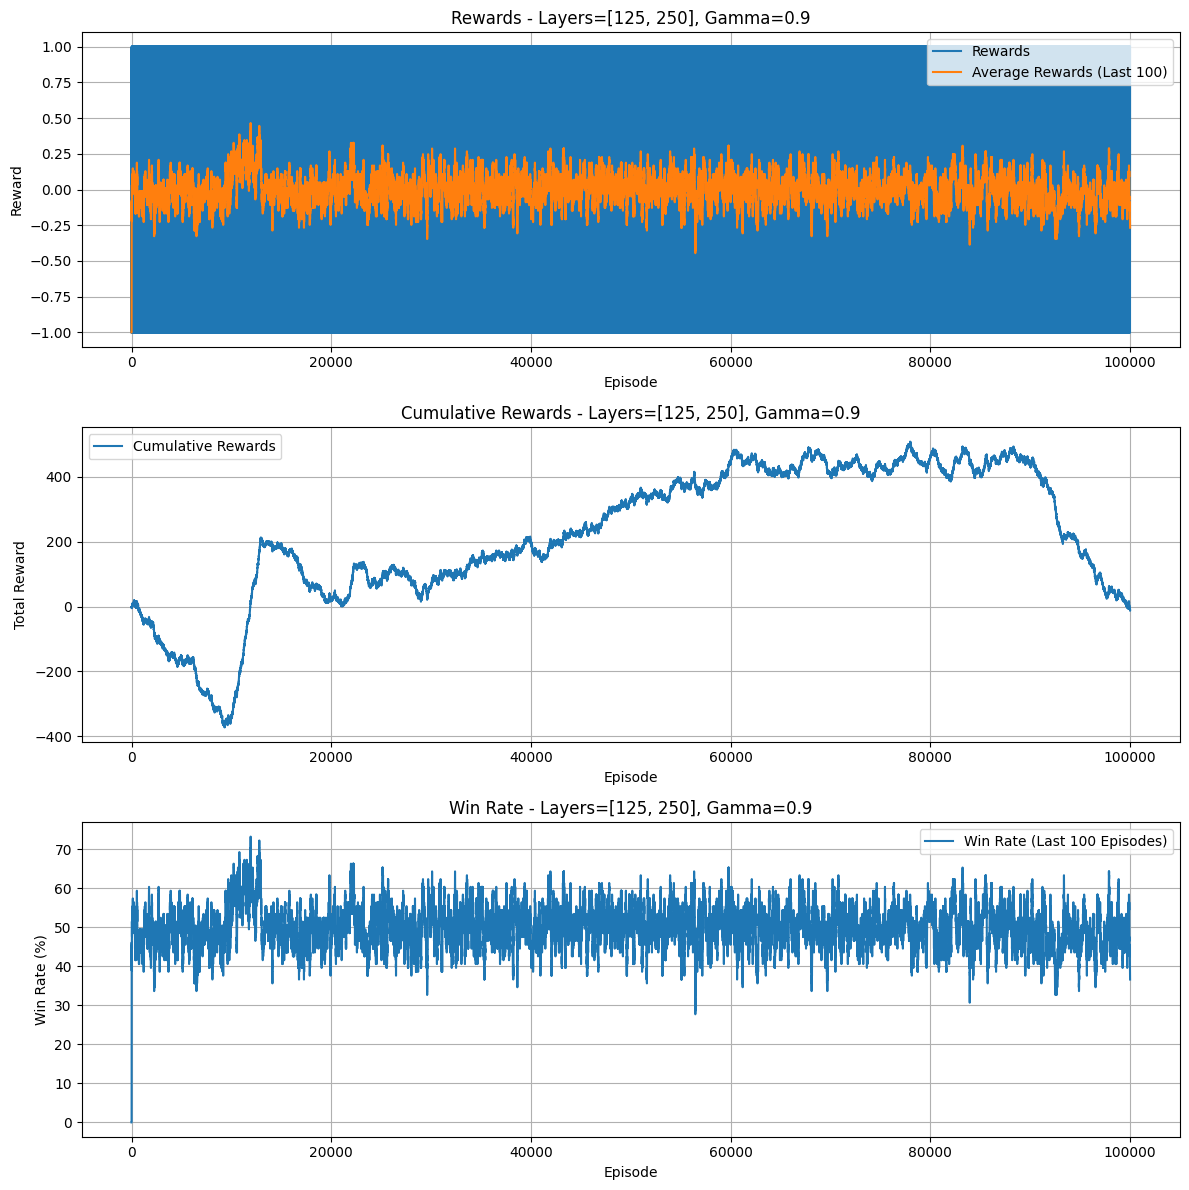

=== Training with LayerStructure=[125, 250] and Gamma=0.85 ===
[10000/100000] Layers=[125, 250], Gamma=0.85, AvgReward(Last100)=0.04, WinRate(Last100)=52.00%, Eps=0.055
[20000/100000] Layers=[125, 250], Gamma=0.85, AvgReward(Last100)=-0.08, WinRate(Last100)=46.00%, Eps=0.050
[30000/100000] Layers=[125, 250], Gamma=0.85, AvgReward(Last100)=-0.24, WinRate(Last100)=38.00%, Eps=0.050
[40000/100000] Layers=[125, 250], Gamma=0.85, AvgReward(Last100)=-0.14, WinRate(Last100)=43.00%, Eps=0.050
[50000/100000] Layers=[125, 250], Gamma=0.85, AvgReward(Last100)=-0.10, WinRate(Last100)=45.00%, Eps=0.050
[60000/100000] Layers=[125, 250], Gamma=0.85, AvgReward(Last100)=-0.16, WinRate(Last100)=42.00%, Eps=0.050
[70000/100000] Layers=[125, 250], Gamma=0.85, AvgReward(Last100)=-0.18, WinRate(Last100)=41.00%, Eps=0.050
[80000/100000] Layers=[125, 250], Gamma=0.85, AvgReward(Last100)=0.16, WinRate(Last100)=58.00%, Eps=0.050
[90000/100000] Layers=[125, 250], Gamma=0.85, AvgReward(Last100)=0.02, WinRate(Last

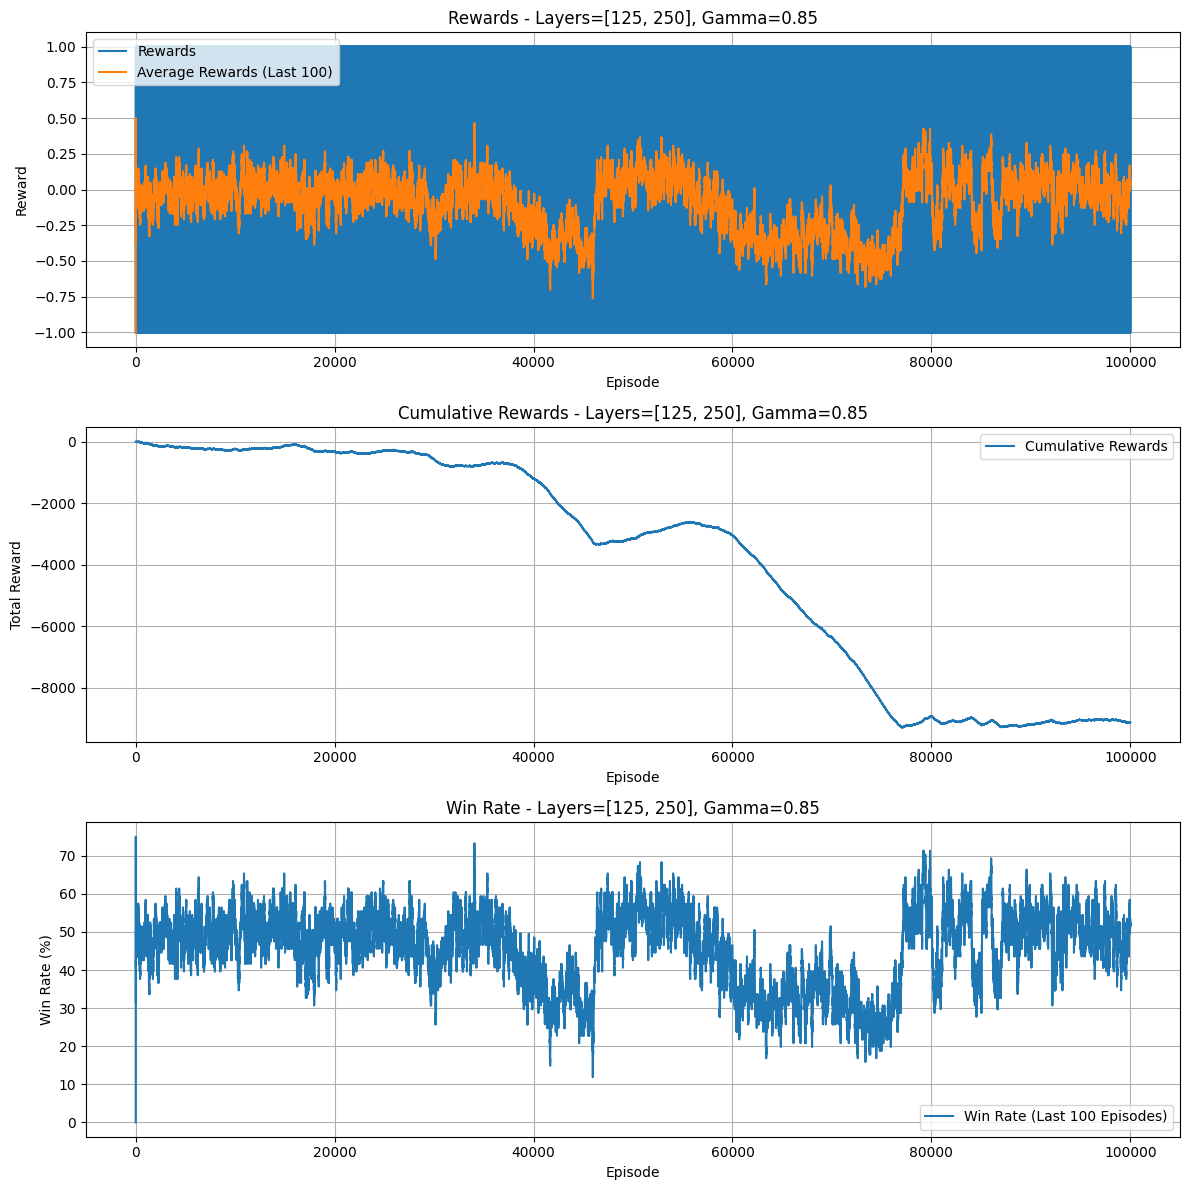

=== Training with LayerStructure=[125, 250] and Gamma=0.8 ===
[10000/100000] Layers=[125, 250], Gamma=0.8, AvgReward(Last100)=-0.02, WinRate(Last100)=49.00%, Eps=0.053
[20000/100000] Layers=[125, 250], Gamma=0.8, AvgReward(Last100)=-0.14, WinRate(Last100)=43.00%, Eps=0.050
[30000/100000] Layers=[125, 250], Gamma=0.8, AvgReward(Last100)=0.36, WinRate(Last100)=68.00%, Eps=0.050
[40000/100000] Layers=[125, 250], Gamma=0.8, AvgReward(Last100)=-0.24, WinRate(Last100)=38.00%, Eps=0.050
[50000/100000] Layers=[125, 250], Gamma=0.8, AvgReward(Last100)=0.26, WinRate(Last100)=63.00%, Eps=0.050
[60000/100000] Layers=[125, 250], Gamma=0.8, AvgReward(Last100)=0.08, WinRate(Last100)=54.00%, Eps=0.050
[70000/100000] Layers=[125, 250], Gamma=0.8, AvgReward(Last100)=0.04, WinRate(Last100)=52.00%, Eps=0.050
[80000/100000] Layers=[125, 250], Gamma=0.8, AvgReward(Last100)=-0.04, WinRate(Last100)=48.00%, Eps=0.050
[90000/100000] Layers=[125, 250], Gamma=0.8, AvgReward(Last100)=0.16, WinRate(Last100)=58.00%,

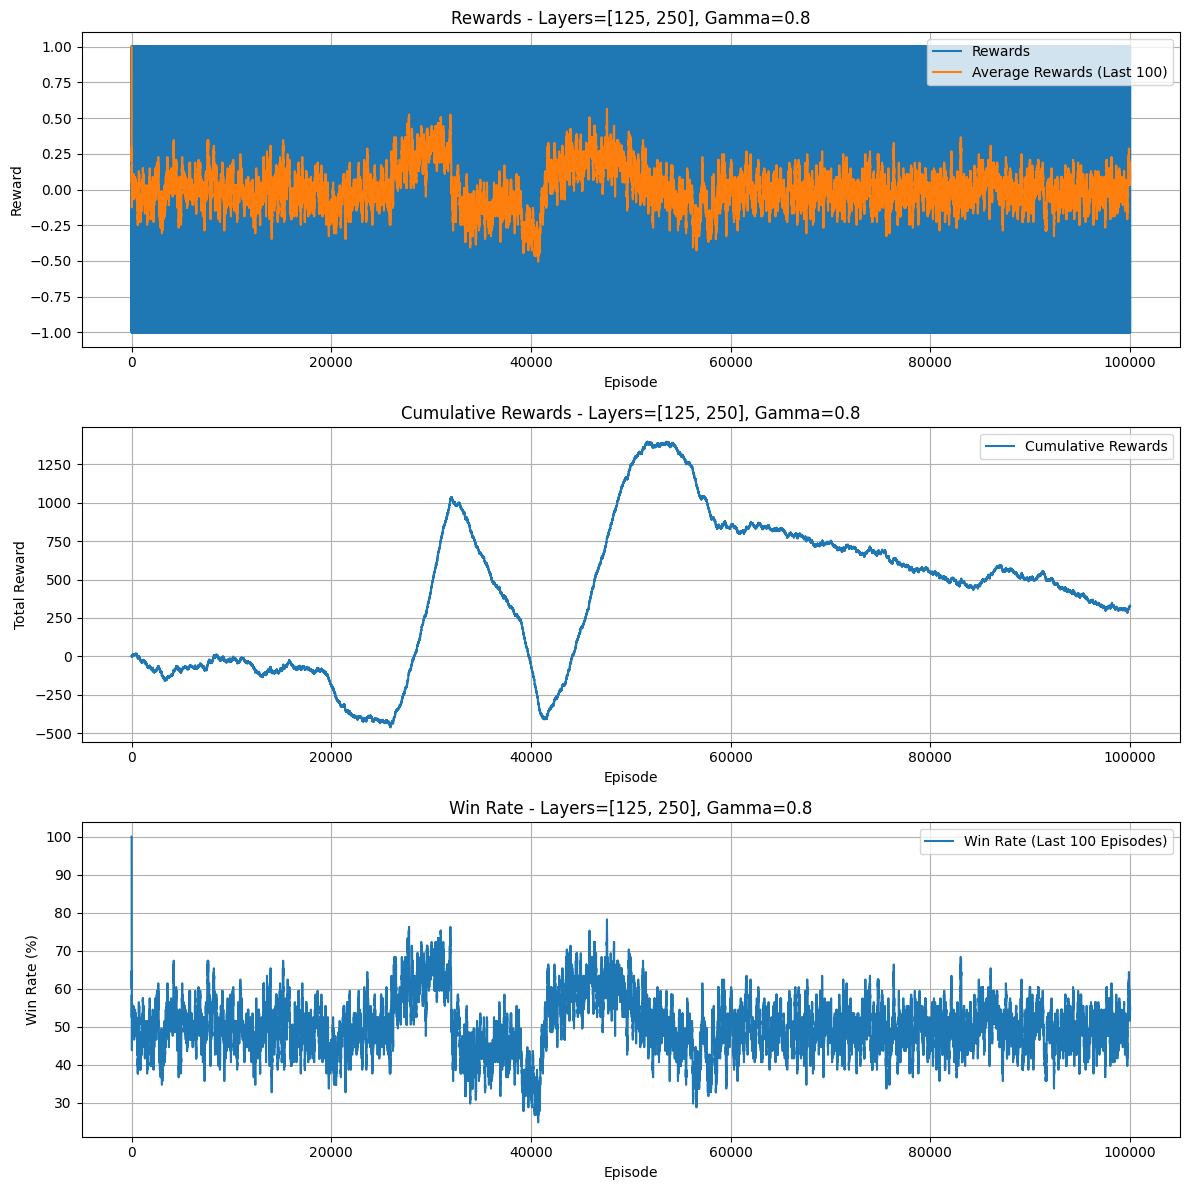

=== Training with LayerStructure=[125, 250] and Gamma=0.75 ===
[10000/100000] Layers=[125, 250], Gamma=0.75, AvgReward(Last100)=-0.12, WinRate(Last100)=44.00%, Eps=0.050
[20000/100000] Layers=[125, 250], Gamma=0.75, AvgReward(Last100)=-0.10, WinRate(Last100)=45.00%, Eps=0.050
[30000/100000] Layers=[125, 250], Gamma=0.75, AvgReward(Last100)=0.06, WinRate(Last100)=53.00%, Eps=0.050
[40000/100000] Layers=[125, 250], Gamma=0.75, AvgReward(Last100)=0.06, WinRate(Last100)=53.00%, Eps=0.050
[50000/100000] Layers=[125, 250], Gamma=0.75, AvgReward(Last100)=-0.08, WinRate(Last100)=46.00%, Eps=0.050
[60000/100000] Layers=[125, 250], Gamma=0.75, AvgReward(Last100)=0.04, WinRate(Last100)=52.00%, Eps=0.050
[70000/100000] Layers=[125, 250], Gamma=0.75, AvgReward(Last100)=-0.06, WinRate(Last100)=47.00%, Eps=0.050
[80000/100000] Layers=[125, 250], Gamma=0.75, AvgReward(Last100)=0.00, WinRate(Last100)=50.00%, Eps=0.050
[90000/100000] Layers=[125, 250], Gamma=0.75, AvgReward(Last100)=-0.10, WinRate(Last1

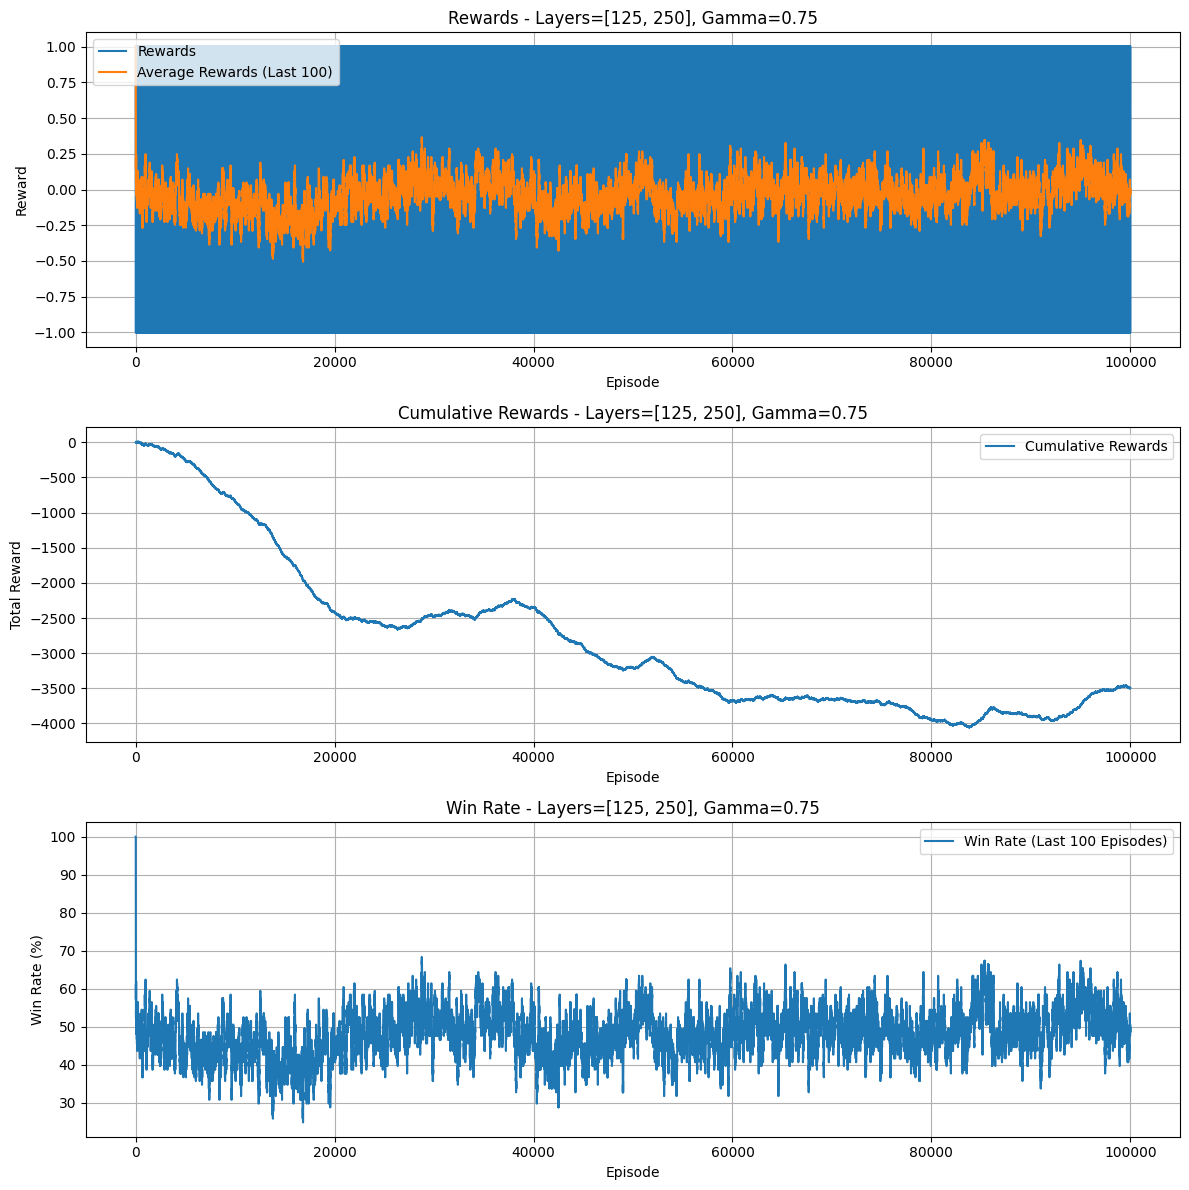

=== Training with LayerStructure=[125, 250] and Gamma=0.7 ===
[10000/100000] Layers=[125, 250], Gamma=0.7, AvgReward(Last100)=-0.14, WinRate(Last100)=43.00%, Eps=0.050
[20000/100000] Layers=[125, 250], Gamma=0.7, AvgReward(Last100)=-0.14, WinRate(Last100)=43.00%, Eps=0.050
[30000/100000] Layers=[125, 250], Gamma=0.7, AvgReward(Last100)=-0.30, WinRate(Last100)=35.00%, Eps=0.050
[40000/100000] Layers=[125, 250], Gamma=0.7, AvgReward(Last100)=-0.30, WinRate(Last100)=35.00%, Eps=0.050
[50000/100000] Layers=[125, 250], Gamma=0.7, AvgReward(Last100)=-0.24, WinRate(Last100)=38.00%, Eps=0.050
[60000/100000] Layers=[125, 250], Gamma=0.7, AvgReward(Last100)=-0.20, WinRate(Last100)=40.00%, Eps=0.050
[70000/100000] Layers=[125, 250], Gamma=0.7, AvgReward(Last100)=-0.10, WinRate(Last100)=45.00%, Eps=0.050
[80000/100000] Layers=[125, 250], Gamma=0.7, AvgReward(Last100)=0.04, WinRate(Last100)=52.00%, Eps=0.050
[90000/100000] Layers=[125, 250], Gamma=0.7, AvgReward(Last100)=-0.04, WinRate(Last100)=48.

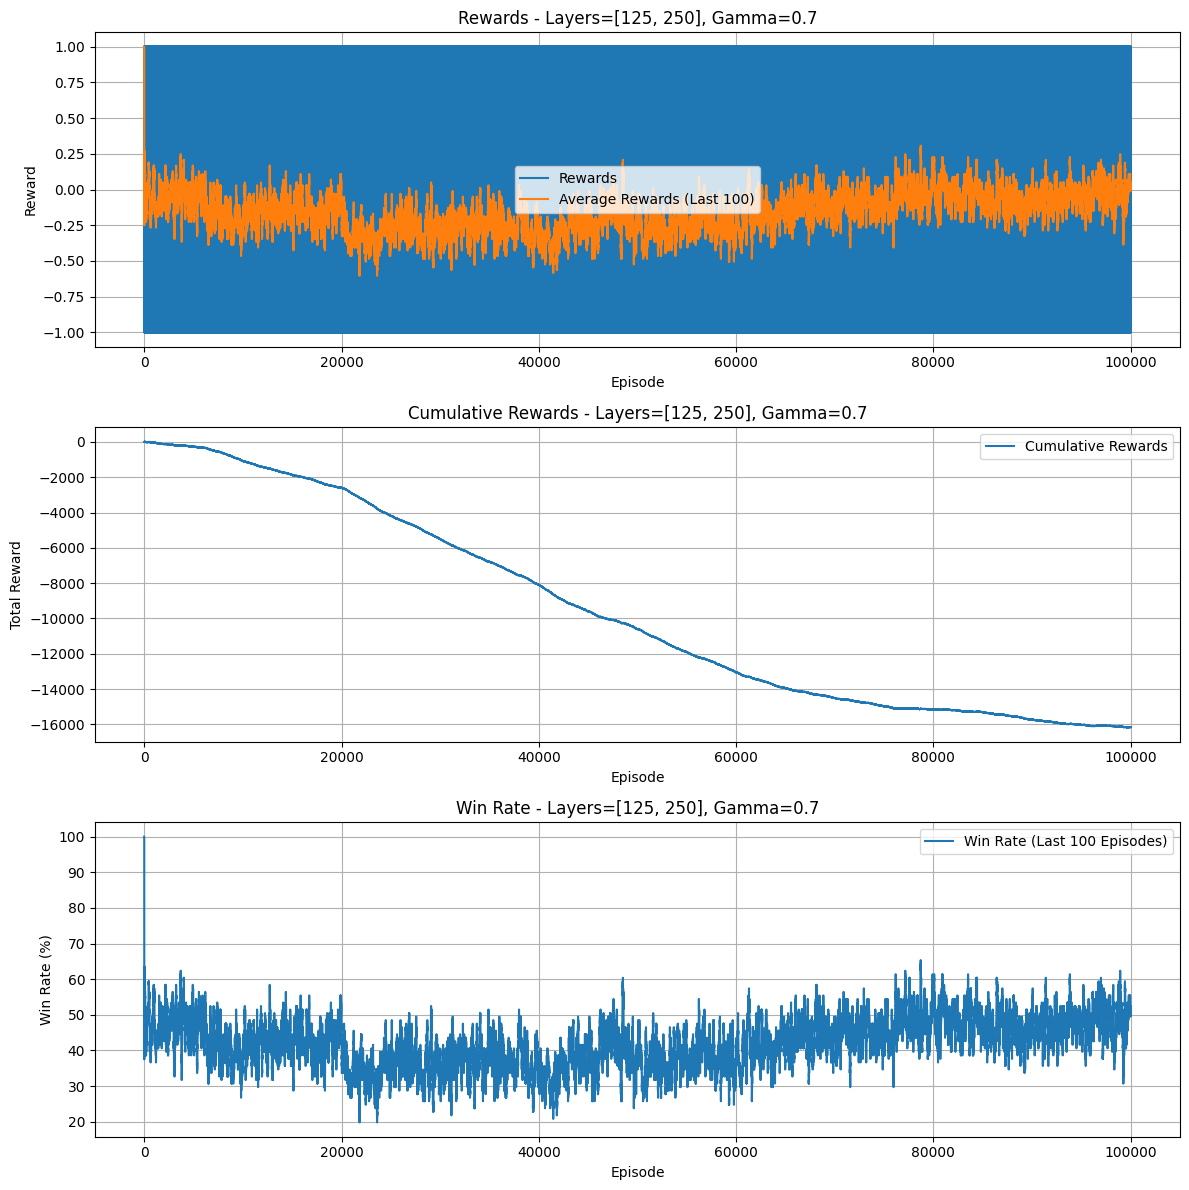

=== Training with LayerStructure=[25, 50, 100, 125] and Gamma=0.95 ===
[10000/100000] Layers=[25, 50, 100, 125], Gamma=0.95, AvgReward(Last100)=0.14, WinRate(Last100)=57.00%, Eps=0.050
[20000/100000] Layers=[25, 50, 100, 125], Gamma=0.95, AvgReward(Last100)=-0.08, WinRate(Last100)=46.00%, Eps=0.050
[30000/100000] Layers=[25, 50, 100, 125], Gamma=0.95, AvgReward(Last100)=0.02, WinRate(Last100)=51.00%, Eps=0.050
[40000/100000] Layers=[25, 50, 100, 125], Gamma=0.95, AvgReward(Last100)=0.12, WinRate(Last100)=56.00%, Eps=0.050
[50000/100000] Layers=[25, 50, 100, 125], Gamma=0.95, AvgReward(Last100)=0.04, WinRate(Last100)=52.00%, Eps=0.050
[60000/100000] Layers=[25, 50, 100, 125], Gamma=0.95, AvgReward(Last100)=0.20, WinRate(Last100)=60.00%, Eps=0.050
[70000/100000] Layers=[25, 50, 100, 125], Gamma=0.95, AvgReward(Last100)=0.20, WinRate(Last100)=60.00%, Eps=0.050
[80000/100000] Layers=[25, 50, 100, 125], Gamma=0.95, AvgReward(Last100)=0.10, WinRate(Last100)=55.00%, Eps=0.050
[90000/100000] L

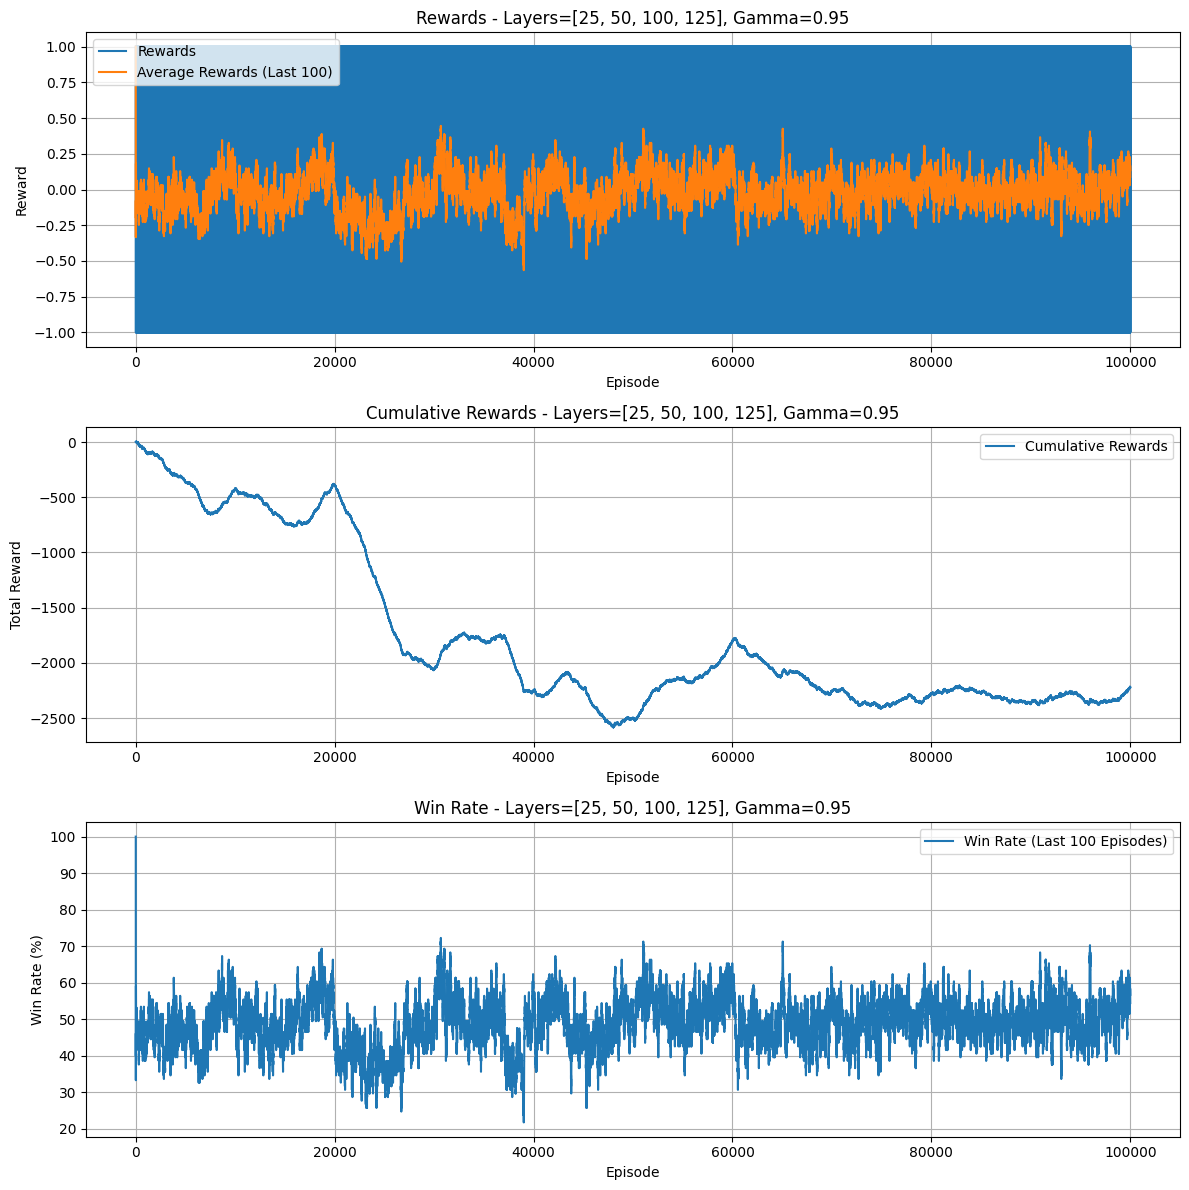

=== Training with LayerStructure=[25, 50, 100, 125] and Gamma=0.9 ===
[10000/100000] Layers=[25, 50, 100, 125], Gamma=0.9, AvgReward(Last100)=-0.08, WinRate(Last100)=46.00%, Eps=0.050
[20000/100000] Layers=[25, 50, 100, 125], Gamma=0.9, AvgReward(Last100)=-0.18, WinRate(Last100)=41.00%, Eps=0.050
[30000/100000] Layers=[25, 50, 100, 125], Gamma=0.9, AvgReward(Last100)=0.32, WinRate(Last100)=66.00%, Eps=0.050
[40000/100000] Layers=[25, 50, 100, 125], Gamma=0.9, AvgReward(Last100)=0.04, WinRate(Last100)=52.00%, Eps=0.050
[50000/100000] Layers=[25, 50, 100, 125], Gamma=0.9, AvgReward(Last100)=0.50, WinRate(Last100)=75.00%, Eps=0.050
[60000/100000] Layers=[25, 50, 100, 125], Gamma=0.9, AvgReward(Last100)=0.18, WinRate(Last100)=59.00%, Eps=0.050
[70000/100000] Layers=[25, 50, 100, 125], Gamma=0.9, AvgReward(Last100)=-0.34, WinRate(Last100)=33.00%, Eps=0.050
[80000/100000] Layers=[25, 50, 100, 125], Gamma=0.9, AvgReward(Last100)=-0.04, WinRate(Last100)=48.00%, Eps=0.050
[90000/100000] Layers=

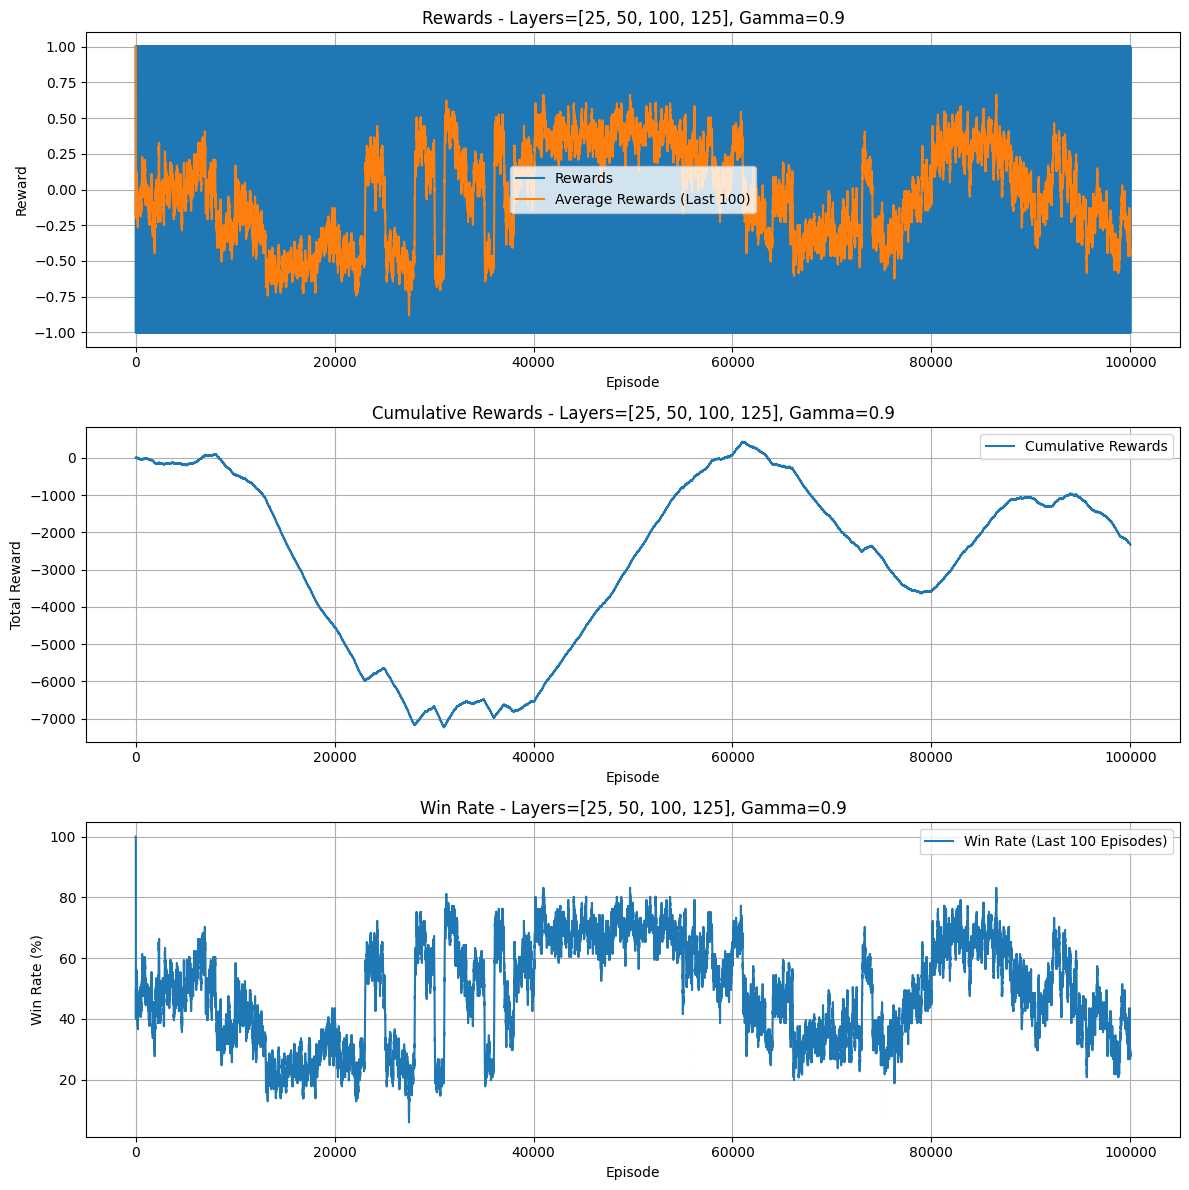

=== Training with LayerStructure=[25, 50, 100, 125] and Gamma=0.85 ===
[10000/100000] Layers=[25, 50, 100, 125], Gamma=0.85, AvgReward(Last100)=-0.12, WinRate(Last100)=44.00%, Eps=0.050
[20000/100000] Layers=[25, 50, 100, 125], Gamma=0.85, AvgReward(Last100)=0.30, WinRate(Last100)=65.00%, Eps=0.050
[30000/100000] Layers=[25, 50, 100, 125], Gamma=0.85, AvgReward(Last100)=-0.24, WinRate(Last100)=38.00%, Eps=0.050
[40000/100000] Layers=[25, 50, 100, 125], Gamma=0.85, AvgReward(Last100)=0.18, WinRate(Last100)=59.00%, Eps=0.050
[50000/100000] Layers=[25, 50, 100, 125], Gamma=0.85, AvgReward(Last100)=-0.10, WinRate(Last100)=45.00%, Eps=0.050
[60000/100000] Layers=[25, 50, 100, 125], Gamma=0.85, AvgReward(Last100)=-0.40, WinRate(Last100)=30.00%, Eps=0.050
[70000/100000] Layers=[25, 50, 100, 125], Gamma=0.85, AvgReward(Last100)=-0.74, WinRate(Last100)=13.00%, Eps=0.050
[80000/100000] Layers=[25, 50, 100, 125], Gamma=0.85, AvgReward(Last100)=-0.60, WinRate(Last100)=20.00%, Eps=0.050
[90000/1000

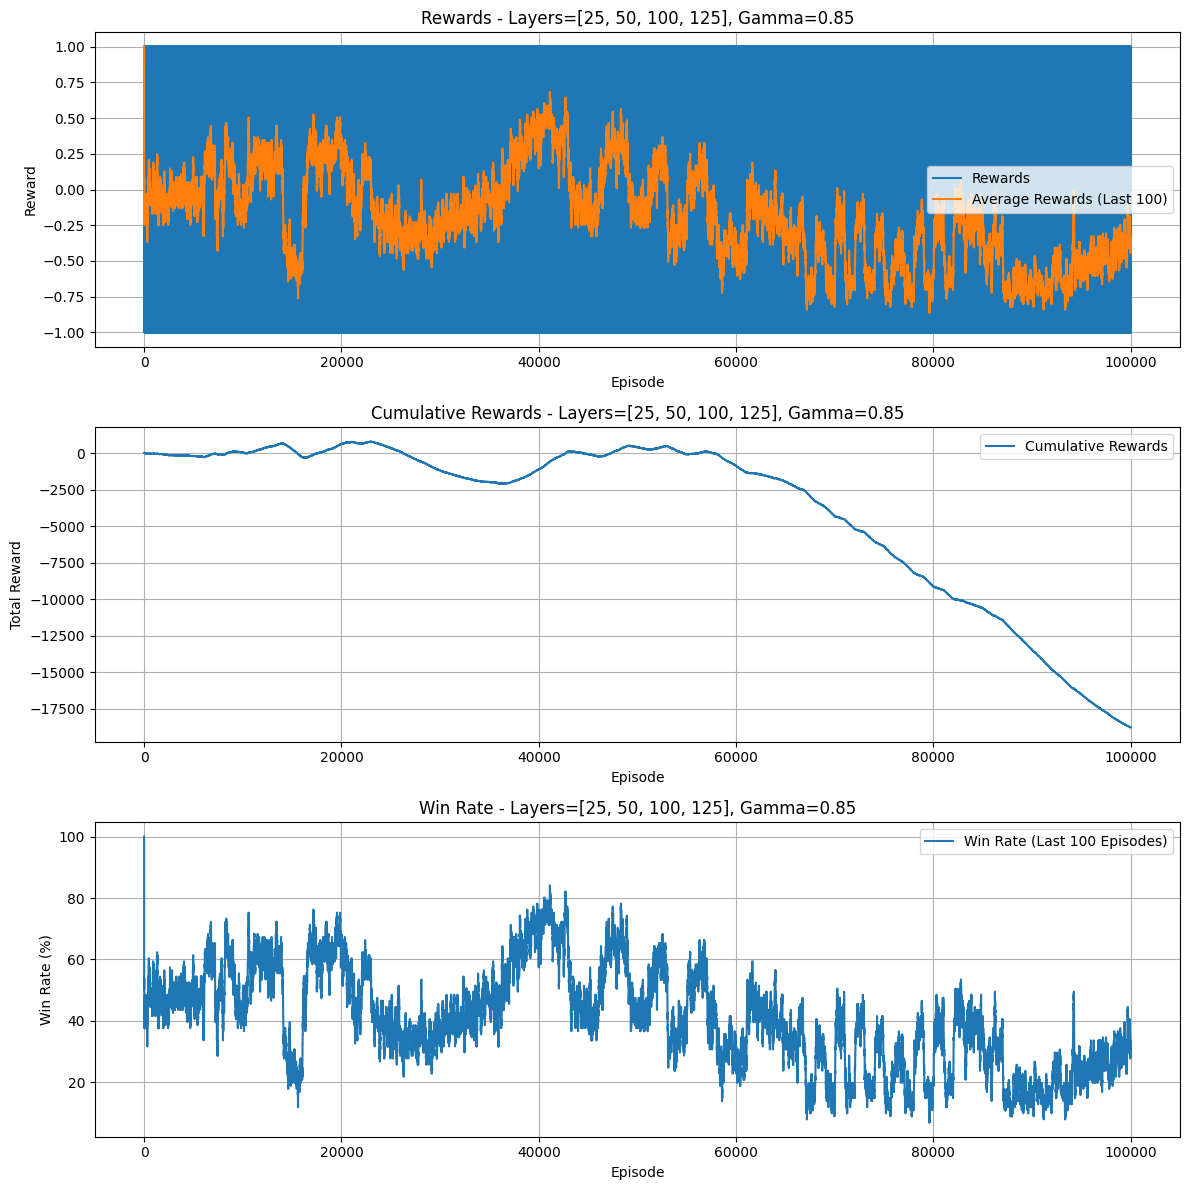

=== Training with LayerStructure=[25, 50, 100, 125] and Gamma=0.8 ===
[10000/100000] Layers=[25, 50, 100, 125], Gamma=0.8, AvgReward(Last100)=-0.42, WinRate(Last100)=29.00%, Eps=0.050
[20000/100000] Layers=[25, 50, 100, 125], Gamma=0.8, AvgReward(Last100)=0.38, WinRate(Last100)=69.00%, Eps=0.050
[30000/100000] Layers=[25, 50, 100, 125], Gamma=0.8, AvgReward(Last100)=0.58, WinRate(Last100)=79.00%, Eps=0.050
[40000/100000] Layers=[25, 50, 100, 125], Gamma=0.8, AvgReward(Last100)=-0.44, WinRate(Last100)=28.00%, Eps=0.050
[50000/100000] Layers=[25, 50, 100, 125], Gamma=0.8, AvgReward(Last100)=-0.48, WinRate(Last100)=26.00%, Eps=0.050
[60000/100000] Layers=[25, 50, 100, 125], Gamma=0.8, AvgReward(Last100)=-0.68, WinRate(Last100)=16.00%, Eps=0.050
[70000/100000] Layers=[25, 50, 100, 125], Gamma=0.8, AvgReward(Last100)=-0.70, WinRate(Last100)=15.00%, Eps=0.050
[80000/100000] Layers=[25, 50, 100, 125], Gamma=0.8, AvgReward(Last100)=-0.70, WinRate(Last100)=15.00%, Eps=0.050
[90000/100000] Layer

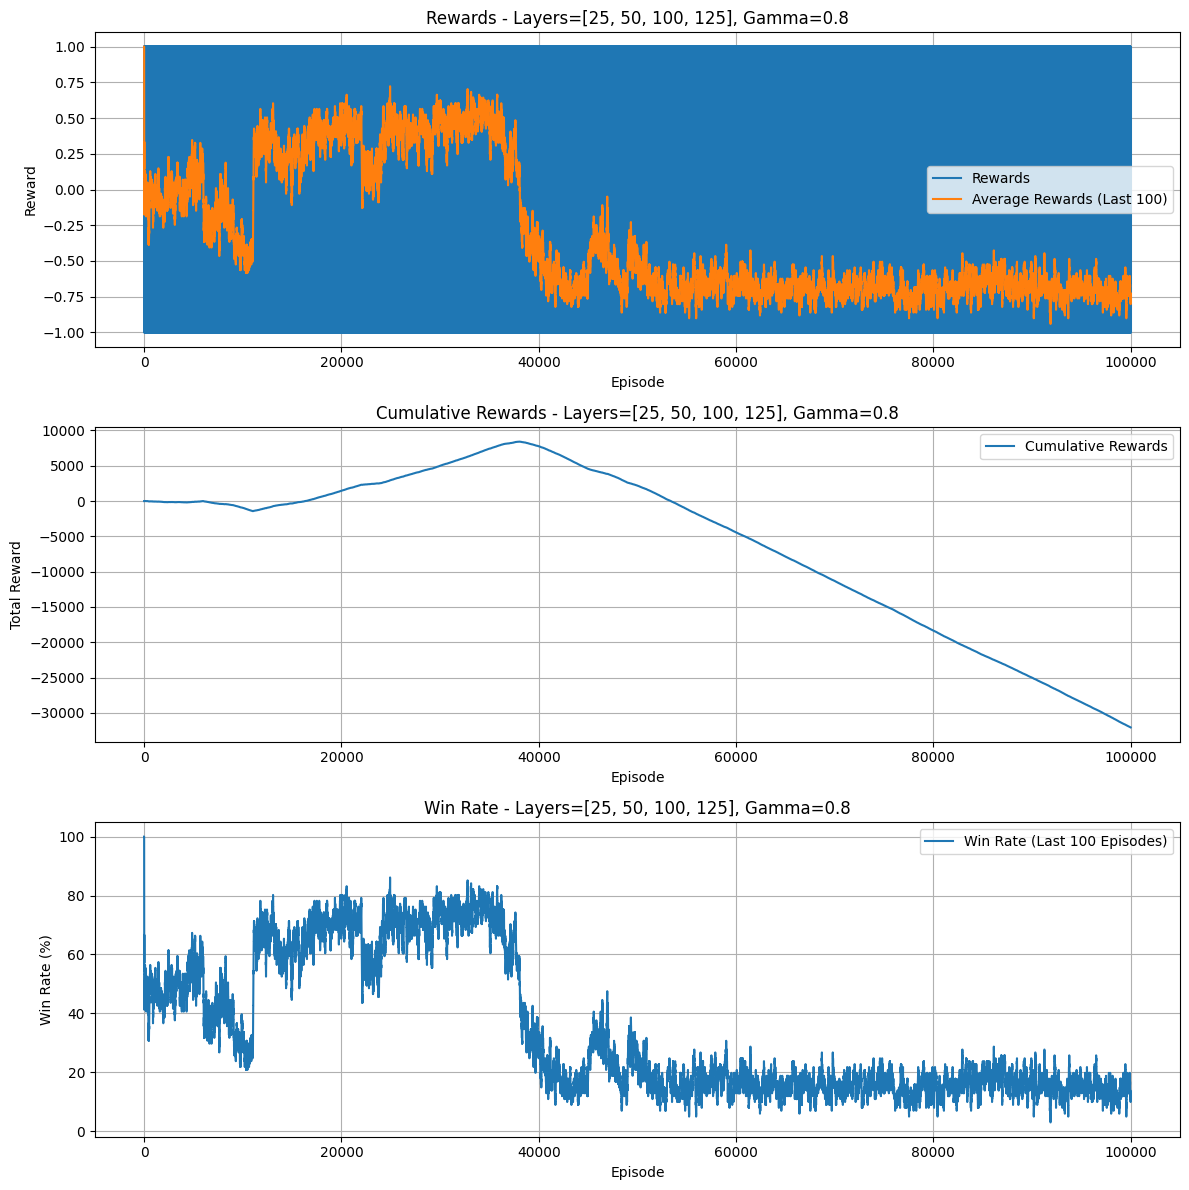

=== Training with LayerStructure=[25, 50, 100, 125] and Gamma=0.75 ===
[10000/100000] Layers=[25, 50, 100, 125], Gamma=0.75, AvgReward(Last100)=-0.50, WinRate(Last100)=25.00%, Eps=0.050
[20000/100000] Layers=[25, 50, 100, 125], Gamma=0.75, AvgReward(Last100)=-0.36, WinRate(Last100)=32.00%, Eps=0.050
[30000/100000] Layers=[25, 50, 100, 125], Gamma=0.75, AvgReward(Last100)=-0.52, WinRate(Last100)=24.00%, Eps=0.050
[40000/100000] Layers=[25, 50, 100, 125], Gamma=0.75, AvgReward(Last100)=-0.48, WinRate(Last100)=26.00%, Eps=0.050
[50000/100000] Layers=[25, 50, 100, 125], Gamma=0.75, AvgReward(Last100)=-0.62, WinRate(Last100)=19.00%, Eps=0.050
[60000/100000] Layers=[25, 50, 100, 125], Gamma=0.75, AvgReward(Last100)=-0.48, WinRate(Last100)=26.00%, Eps=0.050
[70000/100000] Layers=[25, 50, 100, 125], Gamma=0.75, AvgReward(Last100)=-0.64, WinRate(Last100)=18.00%, Eps=0.050
[80000/100000] Layers=[25, 50, 100, 125], Gamma=0.75, AvgReward(Last100)=-0.74, WinRate(Last100)=13.00%, Eps=0.050
[90000/10

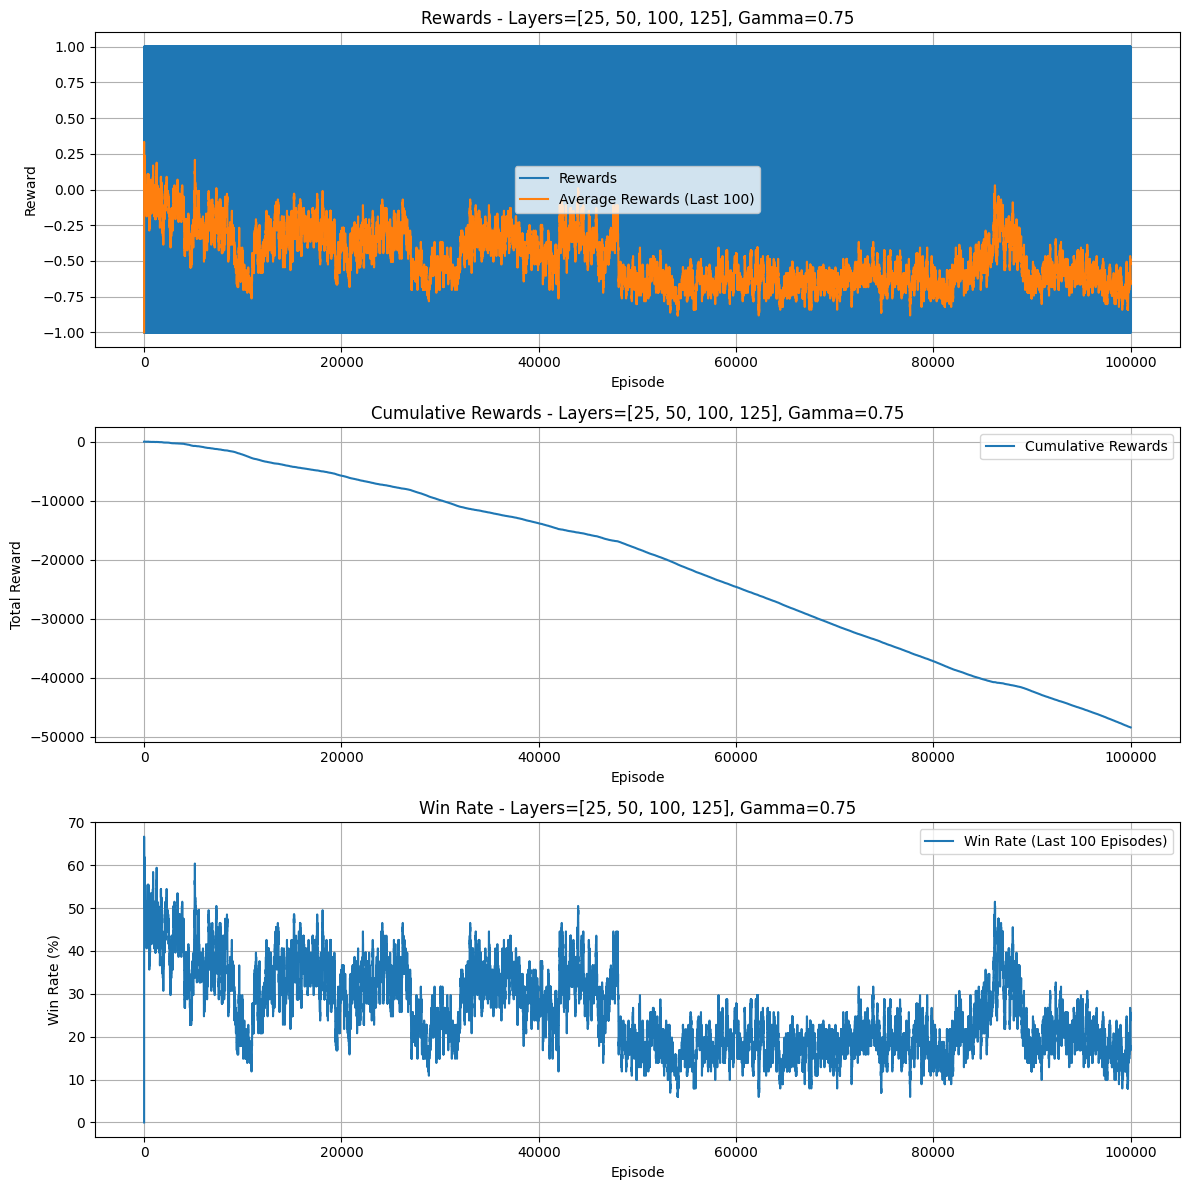

=== Training with LayerStructure=[25, 50, 100, 125] and Gamma=0.7 ===
[10000/100000] Layers=[25, 50, 100, 125], Gamma=0.7, AvgReward(Last100)=-0.36, WinRate(Last100)=32.00%, Eps=0.050
[20000/100000] Layers=[25, 50, 100, 125], Gamma=0.7, AvgReward(Last100)=-0.28, WinRate(Last100)=36.00%, Eps=0.050
[30000/100000] Layers=[25, 50, 100, 125], Gamma=0.7, AvgReward(Last100)=-0.36, WinRate(Last100)=32.00%, Eps=0.050
[40000/100000] Layers=[25, 50, 100, 125], Gamma=0.7, AvgReward(Last100)=-0.50, WinRate(Last100)=25.00%, Eps=0.050
[50000/100000] Layers=[25, 50, 100, 125], Gamma=0.7, AvgReward(Last100)=-0.40, WinRate(Last100)=30.00%, Eps=0.050
[60000/100000] Layers=[25, 50, 100, 125], Gamma=0.7, AvgReward(Last100)=0.62, WinRate(Last100)=81.00%, Eps=0.050
[70000/100000] Layers=[25, 50, 100, 125], Gamma=0.7, AvgReward(Last100)=0.04, WinRate(Last100)=52.00%, Eps=0.050
[80000/100000] Layers=[25, 50, 100, 125], Gamma=0.7, AvgReward(Last100)=-0.18, WinRate(Last100)=41.00%, Eps=0.050
[90000/100000] Layer

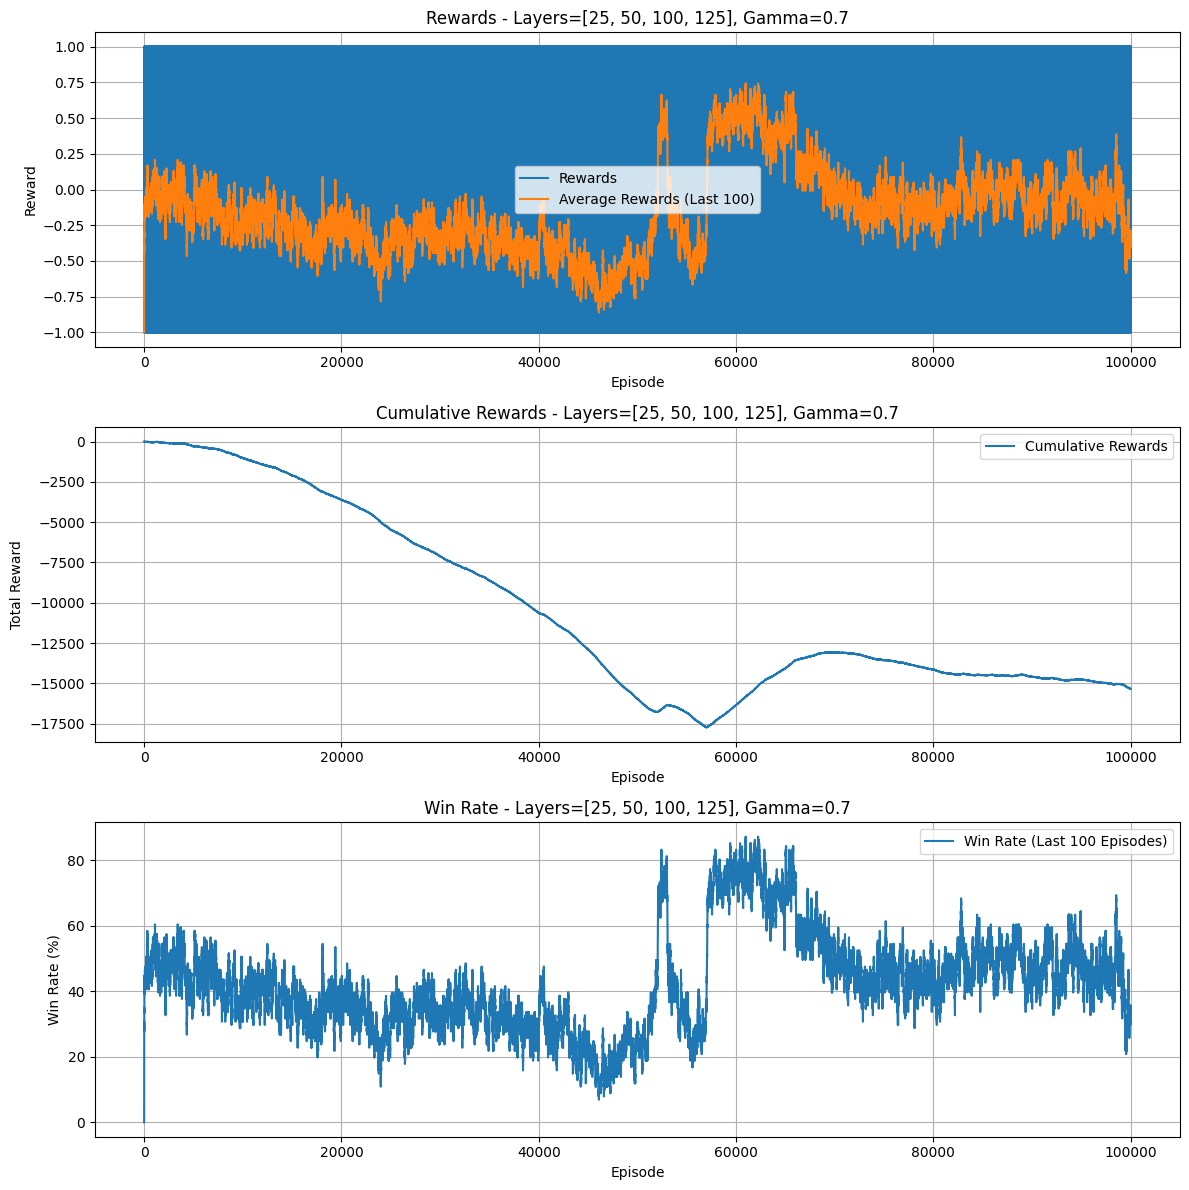

In [196]:
env = TactixEnvironment()
all_results = main_experiments(env) 